# Introduction

***In this post I discuss the preparation of high frequency datasets for Apple (Apple Inc., NASDAQ, ticker: AAPL), JPM (JPMorgan Chase & Co., NYSE, ticker: JPM), and the EURUSD currency pair. I use volatility prediction as my problem setting because the second moment dominates. Careful data cleaning is one of the most important aspects of working with high frequency data and it is not always straightforward to construct a time series of interest from raw tick data. The methods I employ to prepare my data and compute a returns series are therefore are not trivial. I shall use these datasets in several of my subsequent posts, so a thorough exposition of the steps I have taken along with description of the resultant datasets is important. I consider the data from the perspective of the financial econometrician; subsequently I shall contront the data with a variety of deep learning and reinforcement learning methods and a solid understanding of the data will help the interpretation of results. This is a lengthy and detailed post, with many references to supporting research. I hope to show, amongst other things, that simply fitting a time series of asset prices to a deep learning neural network, without proper consideration of the data itself and what it means, is a necessary but not sufficient condition for robust results. Put another way, when we obtain a prediction from our model, how certain can we be that what we observe is signal and not noise.***

# Microstructure noise

In classic models of asset pricing $X$, the log of an asset price, is assumed to follow an Ito semimartingale. This model originates with Bachelier (1900), Osborne (1959), Cootner (1964), Samuelson (1965), and Mandelbrot (1966); the current paradigm was introduced and formalized using stochastic analysis by Merton in a series of seminal contributions (collectively, see Merton (1992). For an asset pricing model to avoid arbitrage opportunities, asset prices must follow semimartingales (see, for example, Ait-Sahalia & Jacod (2014), Robert & Rosenbaum (2012), Delbaen & Schachermayer (1994), and Harrison & Pliska (1981)). A semimartingale can be decomposed into the sum of a drift, a continuous local martingale, and a discontinuous part. The continuous component can be scaled by a stochastic volatility process, which may be correlated with the asset price, and may itself be a semimartingale. From a continuous-time financial econometrics perspective, methods were initially developed to estimate models using low frequency data only (again see Ait-Sahalia & Jacod (2014); also  Ait-Sahalia (1996) and Hansen & Scheinkman (1995)). Subsequent availability of high frequency data then enabled the development of methods with the objective of estimating the volatility component using estimators such as realized volatility (RV) (Liu, Patton & Sheppard (2015) and Andersen, Bollerslev & Diebold (2010) provide detailed reviews). 
$\\[0.1in]$

However, at high frequency (HF), the properties of volatility estimators may be radically altered by the presence of "microstructure noise". This insight stemmed from the development of methods to make high frequency volatility estimators more robust. Initially these methods focused exclusively on models with continuous sample paths. They include, in chronological order, the two scales realized volatility (TSRV) estimator of Zhang, Mykland & Ait-Sahalia (2005), the maximum likelihood approach of Ait-Sahalia, Mykland & Zhang (2005), the multi-scaled realized volatility (MSRV) of Zhang (2006), the realized kernels of Barndorff-Nielsen, Hansen, Lunde & Shephard (2009, 2008, 2007), the preaveraging approach of Jacod, Li, Mykland, Podolski & Vetterd (2009), and the quasi-maximum likelihood estimator of Xiu (2010). This work is augmented by more recent work from Figueroa & Wu (2020), Andersen, Thyrsgaard, & Todorov (2018), Bollerslev, Li, & Xue (2018), Bollerslev, Hood, Huss & Pedersen (2017), along with earlier work by Ait-Sahalia, Mykland & Zhang (2012, 2011), Gatheral & Oomen (2010), Li, Mykland, Renault, Zhang, & Zheng, (2010), Kalnina & Linton (2008), Cheng & Sen (2008), Li & Mykland (2007), Fan & Wang (2007), Hansen & Lunde (2006), Bandi & Russel (2006), and Delattre & Jacod (1997).
$\\[0.1in]$

RV provides a consistent estimate of the quadratic variation of asset prices when prices follow a continuous stochastic model and are directly observed (see, for example, the pioneering papers of Barndorff-Nielsen & Shephard (2002) and Andersen, Bollerslev, Diebold & Labys (2003)). This is compelling and it makes RV a very simple and natural volatility estimator. RV is also, as noted by Ait-Sahalia & Yu (2009), possessed of the most desirable properties. For instance, in the context of parametric volatility models, RV is not only the least squares estimator or the method of moments estimator with the sample variance as the moment function, but also the maximum likelihood estimator. The asymptotic properties of RV are striking when sampling occurs at an increasing frequency that is a realistic approximation to what is observed with, for example, the nano-second NYSE Trades and Quotes and HF FX data that are my data here. In particular, fully observing the sample path of an asset can be shown, in the limit, to perfectly reveal the volatility of that path. This result is nonparametric in nature, in that the estimator will converge to the quadratic variation of the process, and holds in great generality for semimartingales. However, in an HF empirical setting, things are not necessarily as simple as these asymptotic results suggest. Controlling for microstructure noise that is prevalent at high frequencies is a key issue.
$\\[0.1in]$

Microstructure noise captures a wide range of frictions inherent in the information flows associated with the trading process; an insight that goes back to Roll (1984) and Hasbrouck (1993). Ait-Sahalia & Jacod (2014) and Menkveld (2016), for example, describe the frictions as bid-ask bounce, discreteness of price changes, differences in trade sizes or informational content of price changes, gradual response of prices to a block trade, strategic component of the order flow, and inventory control effects. Bacry, Delattre, Hoffmann & Muzy (2013) describe microstructure noise as strong mean reversion effects at small scales. Theoretically, since at least Merton (1980), it is known that spot volatility may be inferred perfectly if the asset price follows a diffusion process and a continuous record of prices is available. But, as shown consistently in academic research, by practitioners, and indeed in my posts on this site, practical implementation presents significant challenges. 
$\\[0.1in]$

Firstly, even within the nano-second time-frames of current market infrastructures and operations, prices are yet only observed at intermittent and discrete points in time. This induces discretization errors. Secondly, and perhaps more importantly, recorded quotes and prices do not reflect direct observations of a frictionless diffusive process. The order book is the dominant system now in financial markets. It matches orders on a price-time priority and keeps track of all previously submitted buy and sell limit orders on a discrete grid of prices. Prices therefore are quoted on this discrete price grid with a Bid-Ask spread, so that markedly different prices may be quoted simultaneously by competing market makers due to a broad range of factors (an expanding body of work has addressed this observation: see for example Stoikov (2020), Dacorogna (2018), Bollerslev, Li & Xue (2018), Lehalle & Mounjid (2018), Lehalle & Laruelle (2014), Robert & Rosenbaum (2012), Andersen, Bollerslev & Meddahi (2011), and  Gatheral & Oomen (2010)). Complications include heterogeneous beliefs (see for example, Rousseau, Boco & Germain (2016) and Diebold & Strasser (2013)), information (Andersen, Bollerslev & Meddahi (2011)), transactions costs (Amihud, Mendelson & Pedersen (2005)), inventory positions (Andersen, Bollerslev & Meddahi (2011)), inter-trade duration (Zikes, Barunik & Shenai (2018), Aldrich, Heckenbach & Laughlin (2014), Chen, Diebold & Schorfheide (2013), Robert & Rosenbaum (2012), Sun & Engle (2007), and Engle (2000)),  volume (Bollerslev, Li & Xue (2018), Ait-Sahalia, Mykland & Zhang (2011), Griffin & Oomen (2011)), and liquidity (Ait-Sahalia & Yu (2009), Ait-Sahalia & Mykland (2009)). Variously at times, often collectively, these complications are labeled microstructure noise. Consequently, any observed price may be regarded to not represent a unique market price but instead an underlying ideal price that is confounded by an error term reflecting the impact of this 'noise'. The biggest contributory factor to microstructure noise has been consistently shown to be Bid-Ask bounce (Lehalle & Laruelle (2014), Ait-Sahalia, Mykland & Zhang (2010), Almgren (2009), Barndorff-Nielsen, Hansen, Lunde & Shephard (2009), Dacorogna, Gencay, Muller, Olsen, & Pictet (2001)). 
$\\[0.1in]$

The importance attributed to Bid-Ask bounce with regard to microstructure noise may be explained as follows. At very high frequencies (i.e. tick data) underlying volatility may be zero. But, buyers and sellers are still present and consequently prices are observed at Bid or Ask, rather than at mid-price. Because of that, if I choose a classical quadratic variation estimate for squared volatility, even with an underlying volatility of zero, I will measure a lot of time ${\left(P_{Ask} - P_{Bid} \right)}^2$.  I may model this with additive noise, $\epsilon_t$, so that, when the mid-price between $0$ and $T$ follows a discretized arithmetic Brownian motion, $P_{\left(k+1 \right)\delta} = P_{k\delta} + \sigma \sqrt{\delta} \xi_{k+1}$, the price I observe at $k\delta$ is $P_{k\delta} + \epsilon_k$. Empirically, $\epsilon_k$ has been shown to approximate to half a bid-ask spread (see for example Lehalle (2012) and Almgren (2009)).
$\\[0.1in]$

Consequently, sampling $\left[ 0, T \right]$ in $N$ intervals $\left( \delta = \frac {T} {N} \right)$, the expectation of the quadratic variation, which should be an estimate of $\int_0^T \sigma_t^2 dt$, may be described:
$\\[0.1in]$

\begin{align}
    U \left(N \right) &= \mathbb{E} \left( \sum_{n=1}^N {\left( P_{n\delta} + \epsilon_n - \left( P_{\left(n-1 \right)\delta} + \epsilon_{n-1} \right) \right)}^2 \right) \\
                      &= \sum_{n=1}^N \mathbb{E} {\left( P_{n \delta} - P_{\left(n-1 \right) \delta} \right)}^2 + \mathbb{E} {\left( \epsilon_n - \epsilon_{n-1} \right)}^2
\end{align}

$\\[0.1in]$
where $U$ is noise, following Barndorff-Nielsen, Hansen, Lunde & Shephard (2007, 2008, 2009).
$\\[0.1in]$

Consequently, the estimate may now be described:
$\\[0.1in]$

\begin{align}
    U \left(N \right) \rightarrow \int_0^T \sigma_t^2 dt + 2Nv
\end{align}

$\\[0.1in]$
where $N \rightarrow +\infty$. Thus, in this setting, the estimate of squared volatility increases linearly with the sampling rate, driven only by the microstructure noise (with variance $v$).
$\\[0.1in]$

Early approaches to the problem of microstructure noise consisted of discarding the data sampled at the highest frequencies, as the 'noisiest', in order to sample instead at 15 minute, 30 minute, or even longer intervals (see Andersen, Bollerslev, Christoffersen & Diebold (2006), Barndorff-Nielsen & Shephard (2007), Meddahi, Mykland & Shephard (2011) for comprehensive reviews of these early approaches). To quote Zhang, Mykland, & Ait-Sahalia (2005), “it is difficult to accept that throwing away data, especially in such quantities, can be an optimal solution”. I may now explicitly incorporate microstructure noise into the analysis, so that estimators make use of all the data, or as much data as I may choose to use. These methods make it possible to decompose the total observed variance into a component attributable to the fundamental price signal and one attributable to the microstructure noise. These estimators may also, in some settings, produce consistent estimates of the magnitude of the market microstructure noise at high frequencies, thereby producing a decomposition of total asset return volatility into fundamental and noise components. At least two distinct approaches to modeling this noise component may be encountered. 
$\\[0.1in]$

Firstly, and most common, is the use of an additive noise that is independent of the efficient price (studies following this approach include  Ait-Sahalia, Mykland & Zhang (2010), Zhang (2006), Ait-Sahalia, Mykland & Zhang (2005), Bandi & Russel (2005), and Zhang, Mykland & Ait-Sahalia (2005)). An additive endogenous component is also considered in Barndorff-Nielsen, Hansen, Lunde & Shephard (2009), through a linear combination of past returns, and in Kalnina & Linton (2008) through the Brownian motion driving the price. A potential limitation of these approaches is that they do not allow for prices discreteness. A second, alternative approach is where microstructure noise is proposed as cases of a contamination of the efficient price through a Markov kernel (this approach is followed in studies by Jacod, Li, Mykland, Podolski, & Vetterd (2009), and Li & Mykland (2007)), and as a rounding error (Delattre & Jacod (1997) and Li & Mykland (2008)). The microstructure noise is respectively partially and fully endogenous in these approaches. 
$\\[0.1in]$

Of the two approaches, additive microstructure noise is the dominant paradigm. It may be explained as follows. Assume a time horizon $\left[ 0, 1 \right]$ and consider a price $P_t$ observed at time $t = \frac {i} {n}, i = 0, ..., n$, taking the form:
$\\[0.1in]$

\begin{align}
    \log{\left(P_{i / n} \right)} = \log{\left(X_{i / n} \right)} + \epsilon^n_i
\end{align}

$\\[0.1in]$
where $X$ is a continuous-time semimartingale, representing an efficient price, and $\epsilon^n_i$ is a microstructure noise term. 
$\\[0.1in]$

The prefix "additive" implies that in this setting I focus upon the properties of the noise process $\epsilon_t = P_t - X_t$. In this way, I obtain quite straightforwardly, firstly data that is close to a semimartingale in lower frequencies (i.e. $P_{i / n} - P_{j / n} \approx X_{i / n} - X_{j / n}$ as soon as $\left(i - j\right) / n$ is large enough); but secondly, data very different from that of a semimartingale in higher frequencies, the noise term becoming increasingly important as the data frequency increases.
$\\[0.1in]$

The model [$X$ - the $\log{\left(P_{i / n} \right)}$ formula immediately above] setting enables important desirable features for the observed price and microstructure noise. Firstly and perhaps most obviously, the separation of the price and the microstructure noise is straightforward. However, I observe discrete prices that are incompatible with observations of a semimartingale at exogenous samping times. The important impact of this discretization effect on various statistical procedures has been emphasized since the mid-1980's (for example Ball (1988), Cho & Frees (1988), and Gottlieb & Kalay (1985)). Secondly, I observe quick oscillations of the transaction price between the Bid-price and the Ask-price, this being of course  the Bid-Ask bounce.
$\\[0.1in]$

# Data

# Data Preparation

Careful data cleaning is one of the most important aspects of volatility estimation with high frequency data and it is not always straightforward to construct a time series of interest from raw high frequency data. The methods I employ to prepare my data and compute log returns therefore are not trivial. I follow the data cleansing procedures set out in Bollerslev, Hood, Huss & Pederson (2017), Barndorff-Nielsen, Hansen, Lunde & Shephard (2009) and Brownlees & Gallo (2006), which are in turn consistent in many respects with Dacorogna, Gencay, Muller, Olsen, & Pictet (2001). Variants of these procedures are also followed in other important research, including Bollerslev, Li & Xue (2018), Ait-Sahalia & Jacod (2012), Ait-Sahalia, Mykland & Zhang (2010), Barndorff-Nielsen, Hansen, Lunde & Shephard (2007, 2008), and Hanson & Lunde (2006). 
$\\[0.1in]$

The consequences of data handling procedures upon subsequent statistical analysis may be significant (Brownlees & Gallo (2006)). For example, Hansen & Lunde (2006) show that removing large numbers of observations can improve volatility estimation. This result may appear counterintuitive, but the reasoning is quite straightforward: An estimator that makes optimal use of all data will typically put high weight on accurate data and be less influenced by the least accurate observations. Barndorff-Nielsen, Hansen, Lunde & Shephard (2009) develop a good analogy for this using the generalized least squares estimator in the classical regression model. Conversely, the precision of the standard least squares estimator can deteriorate when relatively noisy observations are included in the estimation. Thus the inclusion of poor quality observations can cause more harm than good to the least squares estimator. Realized volatility kernels and related estimators "treat all observations equally" (Barndorff-Nielsen, Hansen, Lunde & Shephard (2008)) so that a few outliers can severely influence these estimators. By contrast, I am concerned with the extent to which deep learning and reinforcement learning are able to treat observations differently and perform better as a result.  There is therefore an important balance to be struck in the process of data preparation between too little data cleansing and too much. As a result, a great deal of raw data analysis and trial-and-error experimentation has accompanied the data preparation process described subsequently in this post.
$\\[0.1in]$

My equity data is high frequency tick-by-tick data for two stocks: Apple (Apple Inc., NASDAQ, ticker: AAPL) and JPM (JPMorgan Chase & Co., NYSE, ticker: JPM). The selection of these two particular stocks is ultimately an arbitrary model setting choice. However, Ait-Sahalia & Jacod (2012) show that market microstructure noise is greater in NASDAQ-listed stocks than Dow Jones Industrial Average (DJIA) stocks listed on NYSE. A cursory look at the performance of the stocks over the period of analysis (see Fig 3 for example) suggests prima facie that the behaviour of these two stocks might differ somewhat in ways that are interesting. The data is obtained from the New York Stock Exchange (NYSE) Trade and Quote (TAQ) database. TAQ is an historical archive of daily files containing all trades and quotes for all issues listed and traded on US regulated exchanges for each single trading day. Daily TAQ files thus comprise the entire history of intra-day transactions data for all securities traded on NYSE, Nasdaq and US regional Exchanges (collectively henceforth the Exchange or Exchanges). TAQ consolidates the National Best Bid Offer (NBBO) with quote, trade and other messages from the Exchanges. The NBBO is calculated and disseminated by Security Information Processors (the SIP) as part of the National Market System Plan (NMSP), which is used to process security prices. There are two SIPs responsible for this task: the Consolidated Quotation System gives the NBBO for securities listed on NYSE; and the Unlisted Trading Privileges Quote Data Feed gives the NBBO for securities listed on NASDAQ. The NBBO updates throughout the day with the highest and lowest offers for a security among the Exchanges and market makers. The lowest Ask price and the highest Bid price are displayed in the NBBO and are not required to come from the same Exchange. I obtained TAQ data in the form of compressed historical daily files and extracted it using Python. I used Python to select JPM and AAPL tickers, process the data, analyze, cleanse, consolidate, and prepare it for the computation of WeightedMidPrice log returns. I ultimately consolidate the data into a single time-series. The starting point for data preparation is thus 565 daily files, each comprising several gigabytes of data, or millions of underlying transaction (price-quote) records.  
$\\[0.1in]$

It has been reported since French & Roll (1986) that volatility tends to be higher during Exchange trading hours than non-trading hours. Theory underlying the consistency of volatility measures portrays prices as evolving continuously through time. In actuality, of course, most markets close (i.e. weekends and certain holidays), change their trading hours, and sometimes experience "ghost" hours, where liquidity is very poor despite the markets technically being open (Bollerslev, Li & Xue (2018), Foley & Reynolds (2018), Bollerslev, Hood, Huss & Pederson (2017)). Accordingly, I only retain the trading hours for which liquidity is sufficiently high to ensure a reasonable quality of the high frequency data. For the same reason, I filter out non-public exchange trading. My data cleansing and processing workflow comprises the following steps.
$\\[0.1in]$

I focus upon a continuous window of time from when the first Exchange opens until the last Exchange closes in order to cover the whole trading day. Thus, my window covers pre-market (04:00:00 to 09:29:59), market (09:30:00 to 16:00:00), and extended hours (16:00:01 to 20:00:00). Outside of regular market hours (i.e. market (09:30:00 to 16:00:00)), I observe more spurious Bids and Asks. However, in contrast to, for example, Barndorff-Nielsen, Hansen, Lunde & Shephard (2009), I retain pre-market and extended hours activity because, whilst present in the pre-market and extended hours, spurious activity comprises less than 1% of the data. An example of spurious activity outside of the 04:00 to 20:00 window is bad prices. To illustrate, I verify using historical data enquiry functionality on a Bloomberg terminal that 21-Aug-2019 19:27:05.010227335 APPL has Bid 212.05 versus a NBBO entry in the TAQ data of 112.05 that is detected by my scripts. Given the relatively low level of spurious activity in the pre-market and extended hours windows I elect to retain this data at this point in the workflow and deal with it later (i.e. remove the spurious items) via subsequent data cleansing steps. Also, pre-market and extended hours activity is now (i.e. in my period of observation, 2018-2020) significantly deeper than it was at the time of earlier authors' work, so the information in the pre-market and extended hours windows is potentially significant. Entries with a time stamp outside the 04:00 to 20:00 window are deleted. I observe through preliminary data analysis that outside of the 04:00 to 20:00 window there are a great many more spurious Bids and Asks (>20% under some test conditions), which I attribute to the fact that no real market is being made.
$\\[0.1in]$

I delete entries where Bid and/or Ask equals zero. When multiple quotes have the same time-stamp, I replace them all with a single entry with the median Bid and median Ask price. I delete entries for which the spread is negative and I delete entries for which the spread is more than 50 times the median spread on that day. In order to remove outliers that are missed by these earlier steps, I delete entries for which the mid-quote deviates by more than 10 mean absolute standard deviations from a rolling centered median (excluding the observation under consideration) of 100 observations (50 observations before and 50 after). By basing the window on observation counts I allow it to expand and contract in clock time depending upon the intensity of trading. The choice of 100 observations is ad hoc (Barndorff-Nielsen, Hansen, Lunde & Shephard (2009), for example, use 50), but based upon a considerable amount of experimentation with different settings.
$\\[0.1in]$

Brownlees & Gallo (2006) use a different approach for removing outliers. These authors remove observation $i$ if the condition  $\mid p_i - \bar p_i \left(k\right)\mid \; >\;  3 s_i \left(k\right) + \gamma$ is true, where $\bar p_i \left(k\right)$ and $s_i \left(k\right)$ denote respectively the $\gamma$-trimmed sample mean and sample standard deviation of a neighbourhood of $k$ observations around $i$, where $\gamma$ is a granularity parameter. I use the median in place of the trimmed sample mean, $\bar p_i \left(k\right)$, and the mean absolute deviation from the median in place of $s_i \left(k\right)$. By not using the sample standard deviation I become less sensitive to runs of outliers, in a manner that generally follows Barndorff-Nielsen, Hansen, Lunde & Shephard (2009).
$\\[0.1in]$

I filter out Bids and Asks that are not originating from a public Exchange. Non-public trading, for example trades done internally by broker dealers (i.e. when a broker dealer crosses two orders internally to create a trade, block trades, and/or when two institutional orders are crossed to create a trade), dark pools (i.e. private Exchanges deemed "dark" because the orders cannot be seen), and Over The Counter (OTC) trades, are included in the TAQ daily files along with associated quote activity. Regulation National Market System (Reg NMS), a set of rules passed by the Securities and Exchange Commission (SEC) in 2005, requires all trades to be reported; thus private trading, trades executed outside of public Exchanges, along with associated quote activity are reported to a Trade Reporting Facility (TRF). TRFs are provided by the Exchanges, which then publish to the SIP. Reg NMS allows up to 10 seconds after execution for a report to be sent to a TRF. This can result in the inclusion on the TAQ at a given instance in time of TRF information that is not within the current NBBO and, as a result, prices and sizes may be unrealistic in proximity to TRF information.
$\\[0.1in]$

Evidence is mixed regarding the impact of private trading. O’Hara & Ye (2011) examine effective spreads, realized spreads, execution speed, short-term volatility, and variance ratios and show that fragmentation arising from Reg NMS is associated with lower spreads, faster execution, and prices that are closer to a random walk; however they also find evidence of increased short-term volatility. Conversely, Chung and Chuwonganant (2012) report that Reg NMS has led to increases in quoted and effective spreads, slower execution, and reduced depth, concluding that fragmentation arising from Reg NMS hurts market quality. Foley & Reynolds (2018) and Haslag & Ringgenberg (2016) report similar findings with regard to negative impacts of Reg NMS. Barndorff-Nielsen, Hansen, Lunde & Shephard (2009) report that it is better to analyze Exchanges separately than treat all data as if it was from a single source, and filter TAQ to NYSE entries only in their work.  Hansen & Lunde (2006) also showed that pooling mid-quotes from multiple exchanges can induce additional noise that overshadows the endogenous noise found in single exchange mid-quotes. However, almost a decade later, Bartlett & McCrary (2019), report that delay in information flows onto the SIP from the different Exchanges "is miniscule and becomes smaller every year". These authors show, for example, that SIP-reported NBBO matches a calculated NBBO  without reporting latencies for 97% of observed data. Moreover, they report that this result was generally persistent across the Exchanges.
$\\[0.1in]$

Having prepared the data, I sparsely sample it. The sparse sampling steps are important and relatively complex in execution. Sparse sampling, the process of constructing lower frequency returns from higher frequency data, means for my work the process of constructing 1-minute samples using the TAQ tick data as the starting point. 
$\\[0.1in]$

I organize the data into minutes based upon Open, High, Low, Close (OHLC) quote prices in turn based on the NBBO. Each Bid or Ask quote price thus refers to a NBBO price. Each Exchange publishes its top-of-book price and size at the NBBO price and the NBBO is changed when an Exchange publishes a quote that improves the NBBO. Bid/Ask quotes persist until there is a change due to a trade, improved price, canceled Bid or Ask. I carry forward the NBBO Bid and Ask from the last NBBO event until there is a new NBBO event, which I detect by the presence of a NB flag on the event entry. Table 1 illustrates the construction of 1-minute Bid-Ask prices. I generally show time in nanoseconds using the format: HH:MM:SS.mmmiiinnn (i.e. 10:01:03.121457812).
$\\[0.1in]$

*Table 1. Construction of 1-minute Bid/Ask price*
$\\[0.1in]$

| Time | Event | Price | Note |
| --- | --- | --- | --- |
| 10:01:03.121457812 | Quote Bid NB | 89.14 | New NBBO Bid | 
| 10:01:03.121457812 | Quote Ask NB | 89.16 | New NBBO Ask | 
| 10:01:03.123539214 | Quote Bid | 89.13 | Does not change NBBO | 
| 10:01:30.398287345 | Quote Ask | 89.17 | Does not change NBBO |  
| 10:02:05.010745979 | Quote Bid | 89.15 | Bid better than NBBO Bid | 
| 10:02:05.010853435 | Quote Bid NB | 89.15 | New NBBO Bid |
| 10:02:05.010853435 | Quote Ask NB | 89.16 | NBBO Ask is unchanged |
| 10:02:05.638387498 | Quote Ask | 89.18 | Does not change NBBO |
| 10:03:10.342597249 | Quote Bid | 89.12 | 10.03 minute data |


$\\[0.1in]$
Table 2 illustrates the JPM 10:02 minute with partial fields. The Open Price for Bid and Ask is based upon the last NBBO from 10:01:03.121457812 (i.e. from the 10:01 minute). I detect a new High Bid at 10:02:05.010853435 when the Exchange prints a new NBBO bid at price 89.15. The Close Bid/Ask for the 10:02 minute is the new NBBO.
$\\[0.1in]$

*Table 2. JPM 10:02 minute with partial fields*
$\\[0.1in]$

| OpenMinTime | OpenBidPrice | OpenAskPrice | HighBidTime | HighBidPrice |
| --- | --- | --- | --- | --- |
| 10:02:00.00000000 | 89.14 | 89.16 | 10:02:05.010853435 | 89.15 | 10:02:05.010853435 | 89.16 | 10:02:59.999999999 | 89.15 | 89.16 |

| HighAskTime | HighAskPrice | CloseMinTime | CloseBidPrice | CloseAskPrice |
| --- | --- | --- | --- | --- |
| 10:02:05.010853435 | 89.16 | 10:02:59.999999999 | 89.15 | 89.16 |


$\\[0.1in]$
When the market is crossed (i.e. NBBO Bid > NBBO Ask ) it is not possible to know what is the correct price, so I use the last good NBBO Bid and Ask, including situations where Bid == Ask. OpenMinTime corresponds to OpenBidPrice and OpenAskPrice. CloseMinTime corresponds with CloseBidPrice and CloseBidAsk, which, for my 1 minute data is HH:MM:59.999999999. If there are no changes to both the Bid and Ask in the NBBO during the 1-minute period then, for the Bid: OpenMinTime $=$ HighBidTime $=$ LowBidTime; and OpenBidPrice $=$ HighBidPrice $=$ LowBidPrice $=$ CloseBidPrice. Whilst for the Ask: OpenMinTime $=$ HighAskTime $=$ LowAskTime; and OpenAskPrice $=$ HighAskPrice $=$ LowAskPrice $=$ CloseAskPrice.
$\\[0.1in]$

In order to negate or reduce the impact of microstructure noise, and in particular Bid-Ask bounce, I compute a weighted mid-price (WMP) using the CloseBid and CloseAsk prices and sizes:
$\\[0.1in]$

\begin{align}
    \mathrm{WMP} = I P^a + \left( 1 - I \right) P^b
\end{align}

$\\[0.1in]$
where the weight I is given by the imbalance:
$\\[0.1in]$

\begin{align}
    I = \frac {Q^b} {Q^b + Q^a}
\end{align}

$\\[0.1in]$
where $Q^b$ is the bid size (that is, total volume at the best bid) and $Q^a$ is the ask size. I discuss microstructure noise, Bid-Ask bounce, WMP, and my motivation for using WMP, in detail below (see 6. 'Mitigating microstructure noise').
$\\[0.1in]$

In order to compute a WMP I require of course Bid and Ask sizes. The Bid and Ask sizes for quotes is the total aggregate for the Exchanges with a matching price to the Bid or Ask NBBO price. I illustrate the construction of the Bid and Ask sizes in Tables 3 and 4.
$\\[0.1in]$

*Table 3. Construction of  1-minute Bid/Ask size*
$\\[0.1in]$

| Time | Event | Price | Size | Note |
| --- | --- | --- | --- | --- |
| 10:01:03.121457812 | Quote Bid NB | 89.14 | 2200 | New NBBO Bid | 
| 10:01:03.121457812 | Quote Ask NB | 89.16 | 2400 | New NBBO Ask | 
| 10:01:03.123539214 | Quote Bid | 89.13 |  2300 | Does not change NBBO | 
| 10:01:30.398287345 | Quote Ask | 89.17 | 2200 | Does not change NBBO |  
| 10:02:05.010745979 | Quote Bid | 89.15 | 2500 | Bid better than NBBO Bid | 
| 10:02:05.010853435 | Quote Bid NB | 89.15 | 2500 | New NBBO Bid |
| 10:02:05.010853435 | Quote Ask NB | 89.16 | 2400 | NBBO Ask is unchanged |
| 10:02:05.638387498 | Quote Ask | 89.18 | 2300 | Does not change NBBO |
| 10:02:20.963856911 | Quote Ask | 89.16 | 2200 | Price matches the NBBO Ask |
| 10:03:10.342597249 | Quote Bid | 89.12 | 2100 | 10.03 minute |

$\\[0.1in]$
*Table 4. 10:02 minute with partial fields including size*
$\\[0.1in]$

| OpenMinTime | OpenBidPrice | OpenAskPrice | OpenAskSize | HighBidTime | HighBidPrice | HighAskTime |
| --- | --- | --- | --- | --- | --- | --- |
| 10:02:00.000 | 89.14 | 89.16 | 2400 | 10:02:05.010 | 89.15 | 10:02:05.010 | 

| HighAskPrice | HighAskSize | CloseMinTime | CloseBidPrice | CloseAskPrice | CloseAskSize |
| --- | --- | --- | --- | --- | --- |
| 89.16 | 2400 | 10:02:59.999 | 89.15 | 89.16 | 4600 |

$\\[0.1in]$
I organize the data into a single time series. The data is continuous in the 04:00 to 20:00 window.  The steps above yield 449,389 AAPL and 334,044 JPM one-minute observations. 
$\\[0.1in]$

# Data analysis

I set up my return series, in order to analyze the data as follows.  You can find the code for this on [my github](https://github.com/johncollinsai/post-high-frequency-data).

In [1]:
import warnings
from hfdata import import_hf_data, hf_data
warnings.filterwarnings('ignore')
dfFX, bigF, dat2 = import_hf_data()
bigF, smF, AAPL_rr, JPM_rr, AAPL_lr, JPM_lr, aaplE, aaplF, jpmE, jpmF, dfFX, rrFX, lrFX, fxE, fxF, dat1, dat1E, dat1F, dat2, dat2_rtn, dat2E, dat2F = hf_data(dfFX, bigF, dat2)
print("Equities and FX HF returns series, plus benchmark daily returns series:", "\n", "\n"
      "AAPL returns .shape", AAPL_rr.shape, "\n"
      "JPM returns .shape", JPM_rr.shape, "\n"
      "EURUSD returns .shape", rrFX.shape, "\n"
      "DEXJPUS daily returns.shape", dat1.shape, "\n"
      "simulated daily returns using a Markov-Switching Multifractal volatility framework, where I have set the MSM parameters as:", "\n"
      "kbar = 4", "\n"
      "b = 6", "\n"
      "m0 = 1.6", "\n"
      "gamma_kbar = 0.8", "\n"
      "sig = 2/np.sqrt(252)", "\n"
      "T = 7087, in order to match the shape of the DEXJPUS benchmark daily returns dataset"
      ) 

/home/climatemetrics/posts/high-frequency-data/venv/lib/python3.8/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


Equities and FX HF returns series, plus benchmark daily returns series: 
 
AAPL returns .shape (449389,) 
JPM returns .shape (334044,) 
EURUSD returns .shape (762381,) 
DEXJPUS daily returns.shape (7087, 1) 
simulated daily returns using a Markov-Switching Multifractal volatility framework, where I have set the MSM parameters as: 
kbar = 4 
b = 6 
m0 = 1.6 
gamma_kbar = 0.8 
sig = 2/np.sqrt(252) 
T = 7087, in order to match the shape of the DEXJPUS benchmark daily returns dataset


$\\[0.1in]$
Figure 1 shows the Open, High, Low, and Close Bid-Ask prices for the AAPL dataset. A much greater degree of "bounce" can be seen within the minute (i.e. the High and Low Bid-Ask prices) than in the Open and Close Bid-Ask prices. Figure 2 expands upon this picture by showing Open, High, Low, and Close, each as separate charts. The top two charts, HighBid-HighAsk and LowBid-LowAsk are shown prior to data cleaning. The top two charts in Figure 2 show a not inconsiderable amount of spurious price activity. The main causes for these outliers are TRF trades and Odd Lots. Odd Lots are defined by Exchange rules as trades less than 100 shares in size; they are not subject to Reg NMS rules requiring execution within the current NBBO. As a result, Odd Lot executions may create unrealistic High-Low prices within the minute in which they occur. These outliers are eliminated by the data cleansing. The bottom two charts show OpenBid-OpenAsk and CloseBid-CloseAsk after the sparse sampling and data cleansing processes have completed. Prices are much more tightly aligned, as to be expected as the former is simply a carry forward of the latter.  
$\\[0.1in]$

*Figure 1. Open, High, Low and Close Bid-Ask prices for AAPL from 01-01-2018 to 31-03-2020*
$\\[0.1in]$

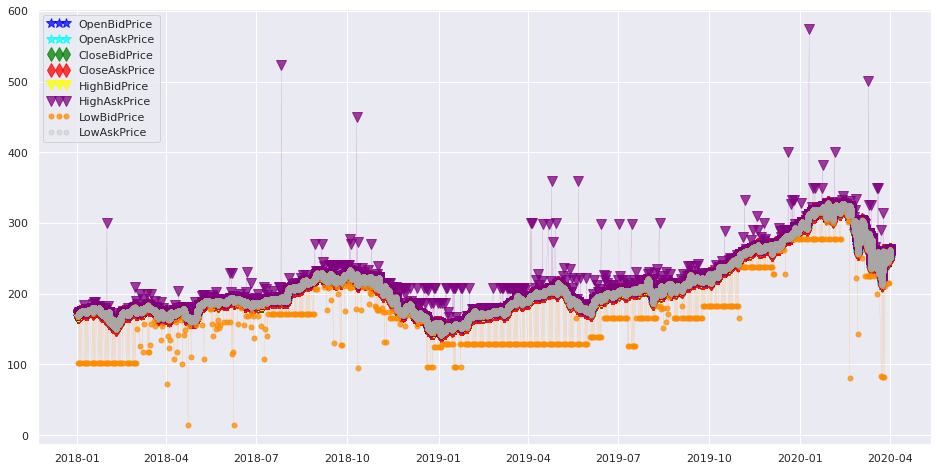

In [2]:
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
import seaborn as sns
sns.set_style("white")
sns.set(rc={'figure.figsize':(16,8)})
import numpy as np
import pandas as pd
j = bigF.loc[bigF['Ticker'] == "AAPL"]
j = j[['Date','OpenBarTime','OpenBidPrice','OpenAskPrice','CloseBidPrice','CloseAskPrice','HighBidPrice','HighAskPrice','LowBidPrice','LowAskPrice']].copy()
j['Date'] = pd.to_datetime(j['Date'].astype(str))
j['Time'] = pd.to_timedelta(j['OpenBarTime'].astype(str))
j['DateTime'] = pd.to_datetime(j['Date'].astype(str)) + pd.to_timedelta(j['OpenBarTime'].astype(str))
line1, = plt.plot(j[['OpenBidPrice']], color='blue', linestyle='solid', linewidth=0.1, marker='*', ms='10', alpha = 0.75, label='OpenBidPrice')
line2, = plt.plot(j[['OpenAskPrice']], color='cyan', linestyle='solid', linewidth=0.1, marker='*', ms='10', alpha = 0.75, label='OpenAskPrice')
line3, = plt.plot(j[['CloseBidPrice']], color='green', linestyle='solid', linewidth=0.1, marker='d', ms='10', alpha = 0.75, label='CloseBidPrice')
line4, = plt.plot(j[['CloseAskPrice']], color='red', linestyle='solid', linewidth=0.1, marker='d', ms='10', alpha = 0.75, label='CloseAskPrice')
line5, = plt.plot(j[['HighBidPrice']], color='yellow', linestyle='solid', linewidth=0.1, marker='v', ms='10', alpha = 0.75, label='HighBidPrice')
line6, = plt.plot(j[['HighAskPrice']], color='purple', linestyle='solid', linewidth=0.1, marker='v', ms='10', alpha = 0.75, label='HighAskPrice')
line7, = plt.plot(j[['LowBidPrice']], color='darkorange', linestyle='solid', linewidth=0.1, marker='.', ms='10', alpha = 0.75, label='LowBidPrice')
line8, = plt.plot(j[['LowAskPrice']], color='darkgrey', linestyle='solid', linewidth=0.1, marker='.', ms='10', alpha = 0.25, label='LowAskPrice')
plt.legend(handler_map={line1: HandlerLine2D(numpoints=3),
                        line2: HandlerLine2D(numpoints=3),
                        line3: HandlerLine2D(numpoints=3),
                        line4: HandlerLine2D(numpoints=3),
                        line5: HandlerLine2D(numpoints=3),
                        line6: HandlerLine2D(numpoints=3),
                        line7: HandlerLine2D(numpoints=3),
                        line8: HandlerLine2D(numpoints=3)});

$\\[0.1in]$
*Figure 2. Open, High, Low, Close Bid/Ask prices plotted separately as a grid, for comparison*
$\\[0.1in]$

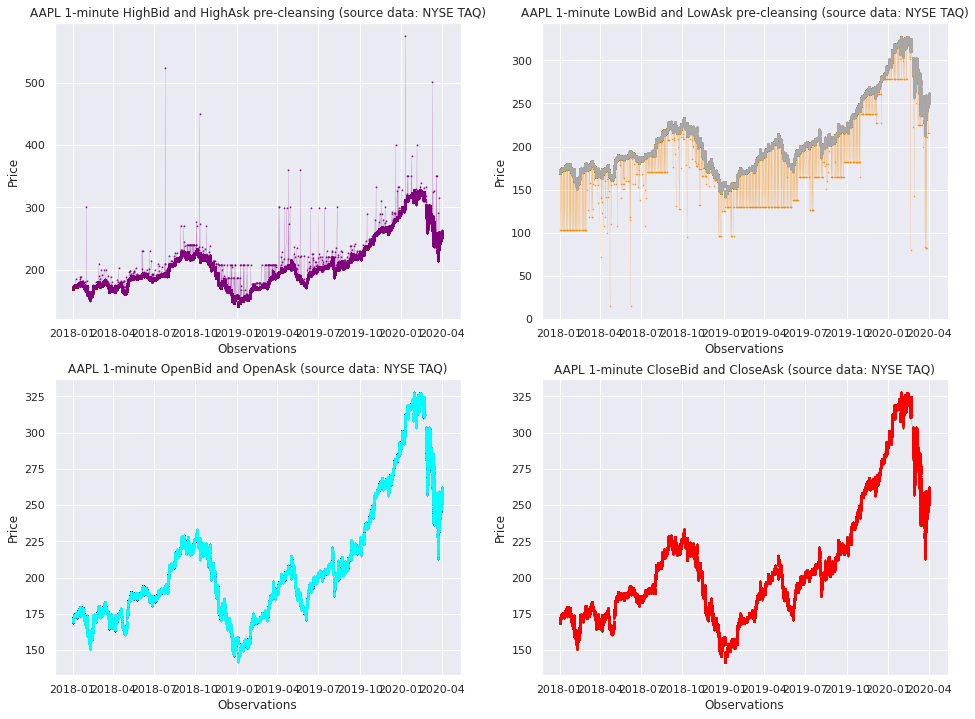

In [3]:
from scipy import stats
import seaborn as sns; sns.set()
np.random.seed(7654321)
fig = plt.figure(figsize=(16,12)) 
j = j[['Date','OpenBarTime','OpenBidPrice','OpenAskPrice','CloseBidPrice','CloseAskPrice','HighBidPrice','HighAskPrice','LowBidPrice','LowAskPrice']].copy()
j['Date'] = pd.to_datetime(j['Date'].astype(str))
j['Time'] = pd.to_timedelta(j['OpenBarTime'].astype(str))
j['DateTime'] = pd.to_datetime(j['Date'].astype(str)) + pd.to_timedelta(j['OpenBarTime'].astype(str))
ax1 = plt.subplot(221)
ax1.set(title="AAPL 1-minute HighBid and HighAsk pre-cleansing (source data: NYSE TAQ)", xlabel="Observations", ylabel="Price");
line5, = plt.plot(j[['HighBidPrice']], color='yellow', linestyle='solid', linewidth=0.1, marker='v', ms='1', alpha = 1, label='HighBidPrice')
line6, = plt.plot(j[['HighAskPrice']], color='purple', linestyle='solid', linewidth=0.1, marker='v', ms='1', alpha = 1, label='HighAskPrice')
ax1 = plt.subplot(222)
ax1.set(title="AAPL 1-minute LowBid and LowAsk pre-cleansing (source data: NYSE TAQ)", xlabel="Observations", ylabel="Price");
line7, = plt.plot(j[['LowBidPrice']], color='darkorange', linestyle='solid', linewidth=0.1, marker='.', ms='1', alpha = 1, label='LowBidPrice')
line8, = plt.plot(j[['LowAskPrice']], color='darkgrey', linestyle='solid', linewidth=0.1, marker='.', ms='1', alpha = 1, label='LowAskPrice')
ax1 = plt.subplot(223)
ax1.set(title="AAPL 1-minute OpenBid and OpenAsk (source data: NYSE TAQ)", xlabel="Observations", ylabel="Price");
ax1.plot(j[['OpenBidPrice']], color='blue', linestyle='solid', linewidth=0.1, marker='*', ms='1', alpha = 1, label='OpenBidPrice')
ax1.plot(j[['OpenAskPrice']], color='cyan', linestyle='solid', linewidth=0.1, marker='*', ms='1', alpha = 1, label='OpenAskPrice')
ax1 = plt.subplot(224)
ax1.set(title="AAPL 1-minute CloseBid and CloseAsk (source data: NYSE TAQ)", xlabel="Observations", ylabel="Price");
line3, = plt.plot(j[['CloseBidPrice']], color='green', linestyle='solid', linewidth=0.1, marker='d', ms='1', alpha = 1, label='CloseBidPrice')
line4, = plt.plot(j[['CloseAskPrice']], color='red', linestyle='solid', linewidth=0.1, marker='d', ms='1', alpha = 1, label='CloseAskPrice')
plt.show();

$\\[0.1in]$
My FX data is high frequency tick-by-tick data for the EURUSD currency pair. The data is obtained from TickData, a data vendor that is widely used by financial institutions and also by other researchers (for example, Bollerslev, Li & Xue (2018), Zikes, Barunik & Shenai (2018), and Bollerslev, Hood, Huss & Pedersen (2016)). I mitigate the effect of market microstructure noise in the FX data by again sparsely sampling it at a 1-minute interval, generally following the data preparation processes described above for the equity data, adapted to fit the alternative source and nature of the underlying data. This yields 762,365 EURUSD one-minute WeightedMidPrice observations. 
$\\[0.1in]$

I use two benchmark datasets. The first is the JPYUSD data series from Calvet and Fisher (2004).  The JPYUSD Foreign Exchange Rate DEXJPUS from 1971-01-04 until now can be downloaded from the Federal Reserve Bank of St. Louis Economic Research FRED website (https://fred.stlouisfed.org/series/DEXJPUS).  I prepare the DEXJPUS dataset by selecting the period 1st June 1973 to 28th June 2002, following Calvet & Fisher (2004). Using an identical dataset to Calvet & Fisher (2004) anchors my work. I see many similarities between the multifractal approach poineered by Calvet & Fisher (2002, 2004, 2007, 2008, 2013, 2015), which of course builds upon the seminal work for Benoit Mandelbrot, and deep learning, which I shall explore in more detail in a subsequent post.
$\\[0.1in]$

1-minute WeightedMidPrices for the three HF time-series and the DEXJPUS daily time-series are presented in Figure 3 where prices are shown on the left axis. Generally prices rise for the first two years of observation (USD strengthens versus EUR in the FX data) and then become extremely volatile, with some of the most violent price movements over a sustained period since the stock market crash preceding the Great Depression (1929-33) observed in the final three months (the first three months of 2020). Figure 4 shows log returns for the same period, with the sharp rise in volatility at the beginning of 2020 clearly evident in all three HF datasets, but particularly so in the log returns for equities, AAPL and JPM. Infrequent very large returns (so-called fat tails) both positive and negative, are seen in all datasets.
$\\[0.1in]$

*Figure 3. AAPL, JPM, EURUSD HF Weighted Mid-Price time series from 01-01-2018 to 31-03-2020, and DEXJPUS daily rates from 01-06-1973 to 28-06-2002*
$\\[0.1in]$

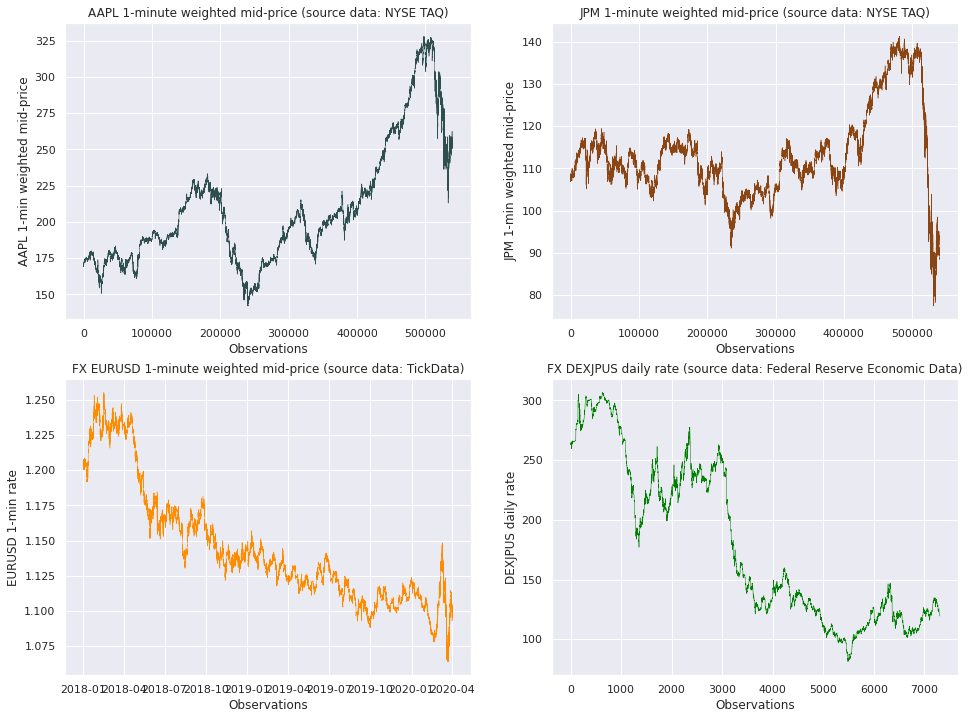

In [4]:
fig = plt.figure(figsize=(16,12))  
j = smF.loc[smF['Ticker'] == "AAPL"]
j = j['WeightedMidPrice']
j = np.array(j).astype(float)
j = j[j != 0].copy()
ax1 = plt.subplot(221)
ax1.set(title="AAPL 1-minute weighted mid-price (source data: NYSE TAQ)", xlabel="Observations", ylabel="AAPL 1-min weighted mid-price");
ax1.plot(j, color='darkslategrey', linewidth=0.5)
j = smF.loc[smF['Ticker'] == "JPM"]
j = j['WeightedMidPrice']
j = np.array(j).astype(float)
j = j[j != 0].copy()
ax2 = plt.subplot(222)
ax2.set(title="JPM 1-minute weighted mid-price (source data: NYSE TAQ)", xlabel="Observations", ylabel="JPM 1-min weighted mid-price") 
ax2.plot(j, color='saddlebrown', linewidth=0.5)
j = dfFX['barCloseBid']
j = j[j != 0].copy()
ax3 = plt.subplot(223)
ax3.set(title="FX EURUSD 1-minute weighted mid-price (source data: TickData)", xlabel="Observations", ylabel="EURUSD 1-min rate") 
ax3.plot(j, color='darkorange', linewidth=0.5)
j = np.array(dat2_rtn).astype(float)
j = j[j != 0].copy()
ax4 = plt.subplot(224)
ax4.set(title="FX DEXJPUS daily rate (source data: Federal Reserve Economic Data)", xlabel="Observations", ylabel="DEXJPUS daily rate") 
ax4.plot(j, color='green', linewidth=0.5)
plt.show();

$\\[0.1in]$
*Figure 4. AAPL, JPM, EURUSD HF Weighted Mid-Price log returns from 01-01-2018 to 31-03-2020, and DEXJPUS daily log returns from 01-06-1973 to 28-06-2002*
$\\[0.1in]$

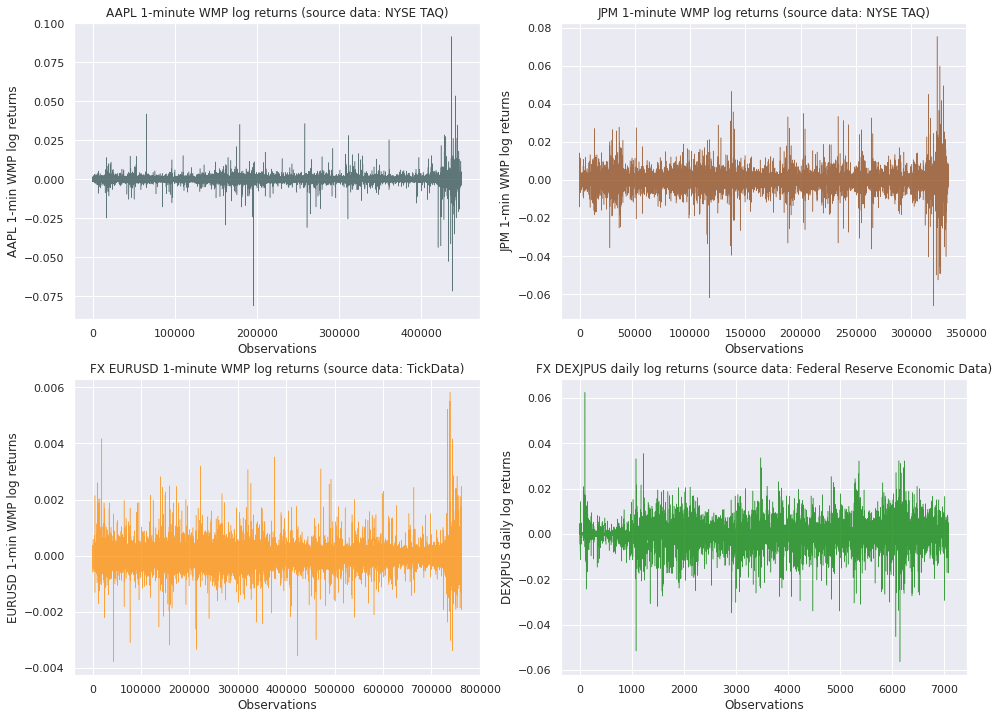

In [5]:
fig = plt.figure(figsize=(16,12))  
AAPL_lr = smF.loc[smF['Ticker'] == "AAPL"]
AAPL_lr = np.log(AAPL_lr['WeightedMidPrice'].astype(float))
AAPL_lr = AAPL_lr - AAPL_lr.shift(1)
AAPL_lr = AAPL_lr[AAPL_lr.notna()].copy()
AAPL_lr = AAPL_lr[AAPL_lr != 0].copy()
JPM_lr = smF.loc[smF['Ticker'] == "JPM"]
JPM_lr = np.log(JPM_lr['WeightedMidPrice'].astype(float))
JPM_lr = JPM_lr - JPM_lr.shift(1)
JPM_lr = JPM_lr[JPM_lr.notna()].copy()
JPM_lr = JPM_lr[JPM_lr != 0].copy()
j = np.array(AAPL_lr).astype(float)
j = j[j != 0].copy()
ax1 = plt.subplot(221)
ax1.set(title="AAPL 1-minute WMP log returns (source data: NYSE TAQ)", xlabel="Observations", ylabel="AAPL 1-min WMP log returns");
ax1.plot(j, color='darkslategrey', linewidth=0.5, alpha=0.75)
j = np.array(JPM_lr).astype(float)
j = j[j != 0].copy()
ax2 = plt.subplot(222)
ax2.set(title="JPM 1-minute WMP log returns (source data: NYSE TAQ)", xlabel="Observations", ylabel="JPM 1-min WMP log returns") 
ax2.plot(j, color='saddlebrown', linewidth=0.5, alpha=0.75)
j = np.array(lrFX).astype(float)
j = j[j != 0].copy()
ax3 = plt.subplot(223)
ax3.set(title="FX EURUSD 1-minute WMP log returns (source data: TickData)", xlabel="Observations", ylabel="EURUSD 1-min WMP log returns") 
ax3.plot(j, color='darkorange', linewidth=0.5, alpha=0.75)
j = np.array(dat2).astype(float)
j = j[j != 0].copy()
ax4 = plt.subplot(224)
ax4.set(title="FX DEXJPUS daily log returns (source data: Federal Reserve Economic Data)", xlabel="Observations", ylabel="DEXJPUS daily log returns") 
ax4.plot(j, color='green', linewidth=0.5, alpha=0.75)
plt.show();

$\\[0.1in]$
Figure 5 superimposes log returns upon prices for for AAPL.  The left axis of Figure 5 is price and the right axis is 1-minute weighted mid-price log returns. Volatility clustering is seen as the amplitude of returns changes frequently from larger to smaller. The superimposed charts also show quite clearly that volatility is higher as prices fall, as they do in the middle of the 28 month time series, and again at the end in response to the COVID-19 outbreak. This is the phenomenon of volatility asymmetry, addressed specifically by, for example, the EGARCH model of Nelson (1991).  
$\\[0.1in]$

*Figure 5. AAPL price time series and log returns from 01-01-2018 to 31-03-2020*
$\\[0.1in]$

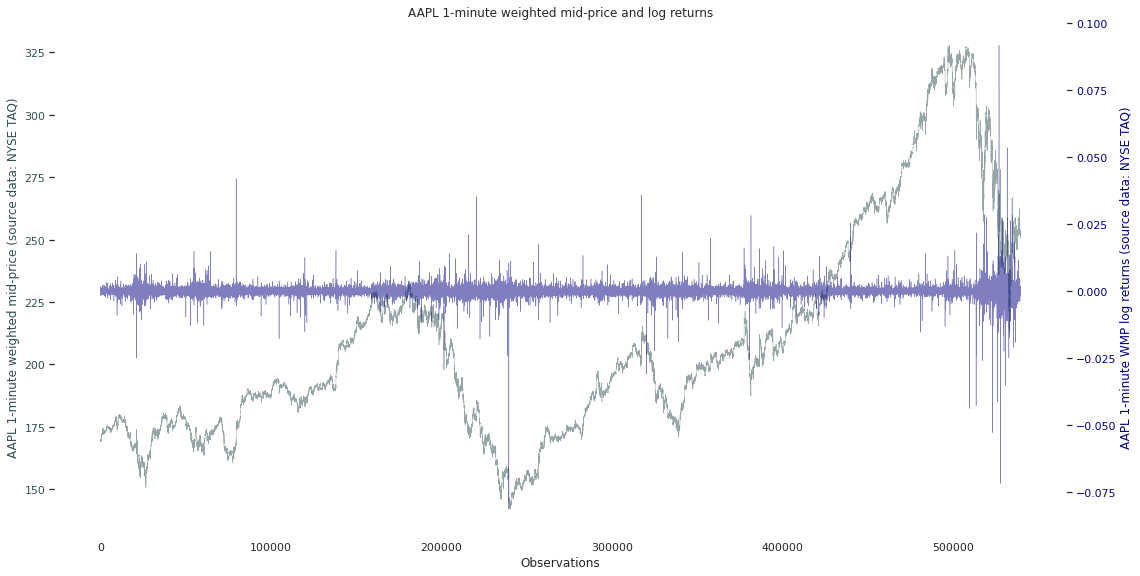

In [6]:
sns.set_style("white")
sns.set(rc={'figure.figsize':(16,8)})
j = smF.loc[smF['Ticker'] == "AAPL"]
j = j['WeightedMidPrice']
j = j[j.notna()].copy()
j = j[j != 0].copy()
k = np.log(j.astype(float))
k = k - k.shift(1)
Q1l = k.quantile(0.00001)   
Q3l = k.quantile(0.99999)   
IQl = Q3l - Q1l
k = k[~((k < (Q1l - 1.5 * IQl)) | (k > (Q3l + 1.5 * IQl)))]
m = len(k)
j = j[:m,]
n_steps = len(j)
t = np.arange(0, n_steps)
data1 = j
data2 = k
fig, ax1 = plt.subplots();
color = 'darkslategrey'
ax1.set_xlabel('Observations');
ax1.set_ylabel('AAPL 1-minute weighted mid-price (source data: NYSE TAQ)', color=color);
ax1.plot(t, data1, linestyle='-', linewidth=0.5, alpha=0.5, color = 'darkslategrey');
ax1.tick_params(axis='y', labelcolor=color);
ax1.set_facecolor('white')
ax1.grid(False)
ax2 = ax1.twinx();
color = 'navy'
ax2.set_ylabel('AAPL 1-minute WMP log returns (source data: NYSE TAQ)', color=color);
ax2.plot(t, data2, linestyle='-', linewidth=0.5, alpha=0.5, color = 'navy');
ax2.tick_params(axis='y', labelcolor=color);
ax2.set_facecolor('white')
ax2.grid(False)
fig.tight_layout();
plt.title("AAPL 1-minute weighted mid-price and log returns");
plt.show();

$\\[0.1in]$
Table 5 reports some features of the datasets; they further illustrate the sylized facts described above: almost unpredictable returns, fat tails, and volatility clustering. The mean is close to zero relative to the standard deviations for all datasets. The standard deviations are naturally observed to be much higher for equities than for FX over the 27 months of observation. The kurtosis of HF datasets is interesting. This of course measures the magnitude of the extremes. If the HF returns are normally distributed, then the kurtosis should be 3. The kurtosis for the equities is very high, approximately 63 for AAPL and even higher, approximately 90, for JPM. It is also very high, approximately 46, for EURUSD. This indicates that the extremes observed in some of the above charts (for example, recall figures 4 and 5) are substantial.
$\\[0.1in]$

*Table 5. Moments for datasets*
$\\[0.1in]$

| | Observations | Mean | Std Dev | Skewness | Kurtosis |
| --- | --- | --- | --- | --- | --- |
| Equities AAPL HF (1-min returns) | 449389 | 0.00023 | 0.15758 | 0.09255 | 62.87348 |
| Equities JPM HF (1-min returns) | 334044 | -0.00003 | 0.14538 | -0.09286 | 89.57130 |
| FX EURUSD HF (1-min returns) | 762365 | -0.00000 | 0.00015 | 0.49364 | 46.37953 |
| DEXJPUS (daily returns) | 7087 | -0.00011 | 0.00666 | -0.38715 | 5.46706 | 
| Simulated data | 7087  | 0.00117 | 0.12705 | -0.12325 | 7.01009 |


$\\[0.1in]$
The standard deviations in table 5 correspond to the annualized (for 2018 and 2019), 3-month (first quarter of 2020), 30-day (March 2020) and 1-day (31st March 2020) volatilities shown in table 6. Extremely high volatilities are observed in the first quarter of 2020, with 30-day volalility for AAPL and JPM at 57% and 37% respectively. There is of course a very pronounced difference between the HF equities and HF FX volatilities. But proportionally, similarly higher volatility in early 2020 is also seen in the EURUSD.
$\\[0.1in]$

*Table 6. Volatilities (Annualized (for 2018 and 2019), 3-month (Q1-2020), 30-day (March 2020) and 1-day (31st March 2020) standard deviations in % for HF datasets)*
$\\[0.1in]$

| | 2018-FY | 2019-FY | 2020-Q1 | 30-Day | 1-Day |
| --- | --- | --- | --- | --- | --- |
| **AAPL** |
| CloseBidPrice | 14.24 | 13.36 | 46.27 | 60.17 | 28.77 |
| CloseAskPrice | 14.35 | 13.54 | 45.58 | 60.16 | 27.74 |
| WeightedMidPrice | 12.75 | 11.98 | 40.66 | 56.72 | 28.52 |
| **JPM** |
| CloseBidPrice | 14.32 | 16.32 | 23.46 | 30.34 | 27.76 |
| CloseAskPrice | 13.84 | 12.72 | 31.98 | 39.22 | 33.09 |
| WeightedMidPrice | 13.92 | 11.99 | 25.48 | 36.77 | 31.72 |
| **EURUSD** |
| CloseBidPrice | 0.015 | 0.011 | 0.021 | 0.036 | 0.028 |
| CloseAskPrice | 0.015 | 0.011 | 0.020 | 0.034 | 0.026 |
| WeightedMidPrice | 0.015 | 0.011 | 0.021 | 0.033 | 0.027 |

$\\[0.1in]$
I now show within my AAPL, JPM, and EURUSD 1-minute returns data some of the key features of observed HF returns distributions and discuss them. For example, how persistent is volatility? And how quickly do financial markets forget large volatility shocks? Figures 7 and 8 show 1-minute WMP returns for AAPL, JPM, and EURUSD exhibit significant autocorrelations over many lags. Initially, volatility models did a relatively poor job of capturing this phenomena. In any stationary ARCH or GARCH model, memory decays exponentially fast. For example, if $\{ \epsilon_t \}$ are ARCH($1$), the $\{ \epsilon_t^2 \}$ have autocorrelations $\rho_k = \alpha^k$. Specifically, if $\alpha = 0.8$ and $k = 20$, then $\rho_{20} = 0.012$. This is likely to be an unrealistically fast decay. Conversely however, for any integrated ARCH or GARCH, $\rho_k = 1$ for all $k$, so there is no decay at all. This of course is unrealistically slow. Neither reflects what my data shows. At one level of abstraction, the progression from ARCH(1) to ARCH($q$) to GARCH represented an attempt to allow for the strong volatility persistence observed in actual data. Typically the exponential decay inherent in any stationary ARCH or GARCH model is too rapid to adequately describe the data, especially HF data, forcing the estimated models to be integrated. In reality, however, volatility may not be integrated, and the behavior of the estimated ARCH and GARCH models may simply be a signal that the memory is decaying relatively slowly compared to the exponential rate, or at several different rates.
$\\[0.1in]$

Figure 6 shows quantile-quantile (Q-Q) plots of  AAPL, JPM, and EURUSD 1-minute, plus DEXJPUS daily returns distributions. Q-Q plots compare the quantiles of two distributions and are a powerful way to visualize points of departure between them. Thus figure 6 plots the empirical quantiles of each dataset against the theoretical quantiles of the Gaussian distribution obtained via maximum likelihood (although the quantiles on the x-axis have been standardized). If the theoretical and empirical densities coincide, their quantiles will exhibit a linear relationship. Departures are highlighted via nonlinearities in the Q-Q plot. I observe that AAPL, JPM and EURUSD 1-minute returns have heavy tails, which indicates that the probability distribution generating the data has higher probabilities of extreme events than a Gaussian distribution. The same is true, but to a lesser extent, for the DEXJPUS daily returns. The characteristic heavy tails of the empirical distributions are visible in the Q-Q plots as a convex-concave departure from linearity. The red line of best fit provides emphasis. The plots are consistent with other published results; for example, Dacorogna (2018) shows 10-minute, 1-day, and 1-week Q-Q plots for USDJPY on a normalized scale to illustrate the extent to which the distribution of 10-minute returns has a distinctly more S-shaped form than 1-day and 1-week returns. I note that my HF data covers the high volatility regime in Q1-2020 (recall the FRED DEXJPUS data covers the period June 1973 to June 2002, following Calvet & Fisher (2004)); the different sampling periods may also therefore be a factor. 
$\\[0.1in]$

*Figure 6. Q–Q (Quantile-Quantile) plots for AAPL, JPM, EURUSD HF Weighted Mid-Prices from 01-01-2018 to 31-03-2020, and DEXJPUS daily rates from 01-06-1973 to 28-06-2002*
$\\[0.1in]$

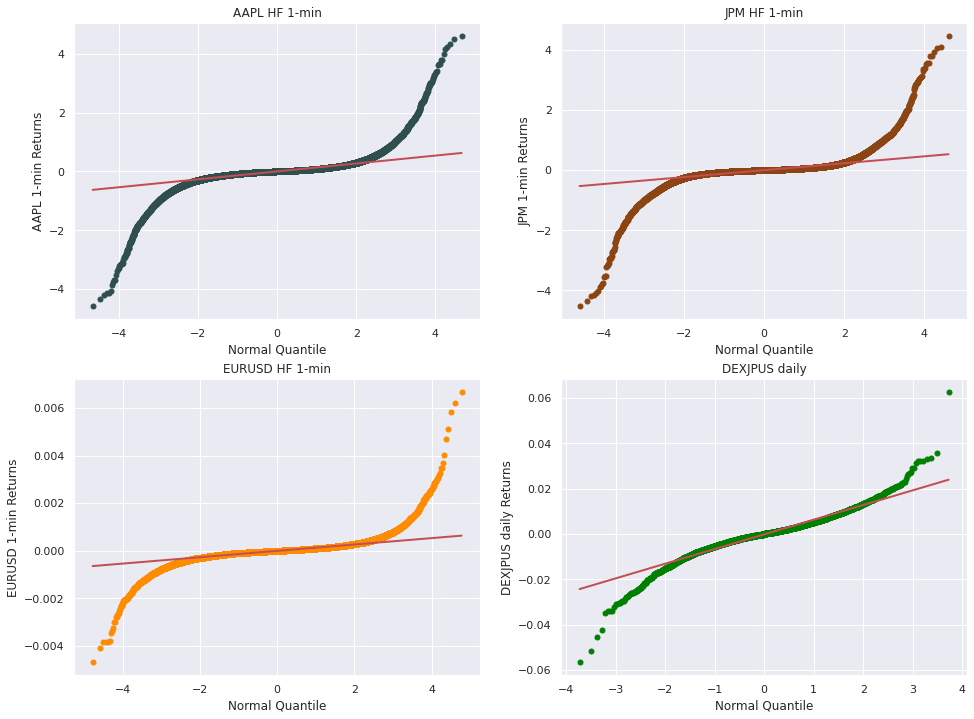

In [7]:
fig = plt.figure(figsize=(16,12))  
s = np.array(AAPL_rr).astype(float)
s = s[s != 0].copy()
ax1 = plt.subplot(221)
res = stats.probplot(s, plot=sns.mpl.pyplot);
ax1.set(title="AAPL HF 1-min", xlabel="Normal Quantile", ylabel="AAPL 1-min Returns");
ax1.get_lines()[0].set_marker('o')
ax1.get_lines()[0].set_markerfacecolor('darkslategrey')
ax1.get_lines()[0].set_markeredgecolor('darkslategrey')
ax1.get_lines()[0].set_markersize(5.0)
ax1.get_lines()[1].set_linewidth(2.0)
s = np.array(JPM_rr).astype(float)
s = s[s != 0].copy()
ax2 = plt.subplot(222)
res = stats.probplot(s, plot=sns.mpl.pyplot);
ax2.set(title="JPM HF 1-min", xlabel="Normal Quantile", ylabel="JPM 1-min Returns") 
ax2.get_lines()[0].set_marker('o')
ax2.get_lines()[0].set_markerfacecolor('saddlebrown')
ax2.get_lines()[0].set_markeredgecolor('saddlebrown')
ax2.get_lines()[0].set_markersize(5.0)
ax2.get_lines()[1].set_linewidth(2.0)
s = np.array(rrFX).astype(float)
s = s[s != 0].copy()
ax3 = plt.subplot(223)
res = stats.probplot(s, plot=sns.mpl.pyplot);
ax3.set(title="EURUSD HF 1-min", xlabel="Normal Quantile", ylabel="EURUSD 1-min Returns") 
ax3.get_lines()[0].set_marker('o')
ax3.get_lines()[0].set_markerfacecolor('darkorange')
ax3.get_lines()[0].set_markeredgecolor('darkorange')
ax3.get_lines()[0].set_markersize(5.0)
ax3.get_lines()[1].set_linewidth(2.0)
s = np.array(dat2).astype(float)
s = s[s != 0].copy()
ax4 = plt.subplot(224)
res = stats.probplot(s, plot=sns.mpl.pyplot);
ax4.set(title="DEXJPUS daily", xlabel="Normal Quantile", ylabel="DEXJPUS daily Returns") 
ax4.get_lines()[0].set_marker('o')
ax4.get_lines()[0].set_markerfacecolor('green')
ax4.get_lines()[0].set_markeredgecolor('green')
ax4.get_lines()[0].set_markersize(5.0)
ax4.get_lines()[1].set_linewidth(2.0)
plt.show()

$\\[0.1in]$
Figures 7 and 8 plot sample autocorrelograms for log returns and squared log returns respectively for the HF datasets considered in the Q-Q plots of figure 6. The autocorrelograms (which may also be referred to as autocorrelation function (ACF) plots or autocorrelation plots), enable visualization of the autocorrelation of the HF time-series at defined time lags. Where no relationship exists between the times-series and its lagged values, autocorrelations should be near zero for any and all time-lag separations. If however relationships exist, then one or more of the autocorrelations will be significantly non-zero. The autocorrelogram represents this visually.
$\\[0.1in]$

Figure 7 shows log return autocorrelograms for AAPL, JPM, EURUSD 1-min Bid, Ask, and Weighted Mid-Prices with 798, 593, and 1354 lags, which equate to approximately 1 day, respectively. 5% significance bands are shown as darker grey zones and the autocorrelograms are based upon full datasets (i.e. 27 months of HF data). Lags are plotted on the x-axis, versus correlations on the y-axis. In the case of AAPL, the top 3 charts in the panel, 1 day's lags equates to 798 lags, for JPM it is 593 lags, and for EURUSD it is 1,354 lags. 95% confidence intervals are also shown, where I have computed the standard deviation using Bartlett's (1946) formula; the upper and lower 5% significance limits for the autocorrelations are shown by the dark grey zones. I exclude the 0-lag autocorrelation for the purposes of drawing the plots because it is visually distorting. The autocorrelograms are computed thus:
$\\[0.1in]$

Let $\hat \mu$ estimate the mean, $\mu$, of one of my HF time series, $X_t$, where:
$\\[0.1in]$

\begin{equation}
    \hat \mu =
    \begin{cases}
    \mu  & \text{for  } \mu \text{  known} \\
    \frac {1} {n} \sum^n_{t=1} X_t & \text{for  } \mu \text{  unknown} 
    \end{cases}
\end{equation}

$\\[0.1in]$
I estimate the autocovariance function $\sigma \left( k \right)$ thus:
$\\[0.1in]$

\begin{align}
    \hat \sigma \left( k \right) = \frac {1} {n} \sum^n_{t=1} \left( X_t - \hat \mu \right) \left(X_{t+k} - \hat \mu \right), \; \; \; \; \; \; k = 0, 1, 2, ... K
\end{align}

$\\[0.1in]$
where $K = \mathrm{max lag}$. I estimate the autocorrelation function $\rho \left( k \right)$ thus:
$\\[0.1in]$

\begin{align}
    \hat \rho \left( k \right) = \frac {\hat \sigma \left( k \right)} {\hat \sigma \left( 0 \right)}, \; \; \; \; \; \; k = 0, 1, 2, ... K
\end{align}

$\\[0.1in]$
and note that $\hat \sigma \left( 0 \right)$ is an estimate of the sample variance, whilst $\hat \rho \left( 0 \right) \equiv 1$, by definition. 
$\\[0.1in]$

As noted above, I write onto the plot a confidence interval (95%) by computing the standard deviation using Bartlett's (1946) formula, which is based upon a general asymptotic expression for the variance of the autocorrelation coefficient. Theoretically, the formula upon which my code is based is written:
$\\[0.1in]$

\begin{align}
    \mathrm{Var} \{\hat \rho \left( k \right) \} = \frac {1} {n} \sum_{i=-\infty}^{\infty} \left[ \rho^2 \left(i \right) + \rho \left( i - k \right) \rho \left(i + k \right) - 4 \rho \left( i \right) \rho \left( k \right) \rho \left( i - k \right) + 2 \rho^2 \left( i \right) \rho^2 \left( k \right) \right]
\end{align}

$\\[0.1in]$
where $\hat \rho \left( k \right)$ assumes $\mu$ is unknown. These confidence intervals may also be referred to as Bartlett bands, in this case 95% Bartlett bands, as in, for example Andersen, Bollerslev, Christoffersen & Diebold (2011).
$\\[0.1in]$

In my implementation, the autocorrelations $\rho \left( k \right)$ are replaced by their estimates $\hat \rho \left( k \right)$ for $\left| k \right| \leq K$, and the limits of summation are in fact bounded by the assumption that $\rho \left( k \right) = 0$ for all $k$ so that $\left| k \right| > K$.
$\\[0.1in]$

It is widely shown that returns are strongly serially correlated, often with very slowly decaying autocorrelations and that volatility long memory dynamics are illustrated by hyperbolic decay (Bollerslev (2010) provides a summary). Predictability may show up as significant autocorrelations in returns, whilst volatility
clustering will show up as significant autocorrelations in squared returns. In figure 7 all autocorrelograms exclude the 0-lag autocorrelation, being typically 1 as the data is correlated with itself, in order to scale the y-axis better for lags $k = 1, 2, ... K$. In all cases therefore the first lag is negative and I observe a significant and initially sharply decaying autocorrelation beyond the first lag. Thereafter the autocorrelations are dispersed, many are significant, some not, and exhibit a channel-type pattern, quite tightly in the case of JPM and more loosely in the cases of AAPL and EURUSD. In the 1-day autocorrelogram panel there does not appear to be a visually obvious difference between the WMP and the Bid or Ask plots. 
$\\[0.1in]$

*Figure 7. Autocorrelograms for AAPL, JPM, EURUSD 1-minute samples; Bid, Ask, and Weighted Mid-Prices with 798, 593, and 1354 (i.e. 1 day equivalent) lags respectively. 5% significance bands shown as darker grey zones*
$\\[0.1in]$

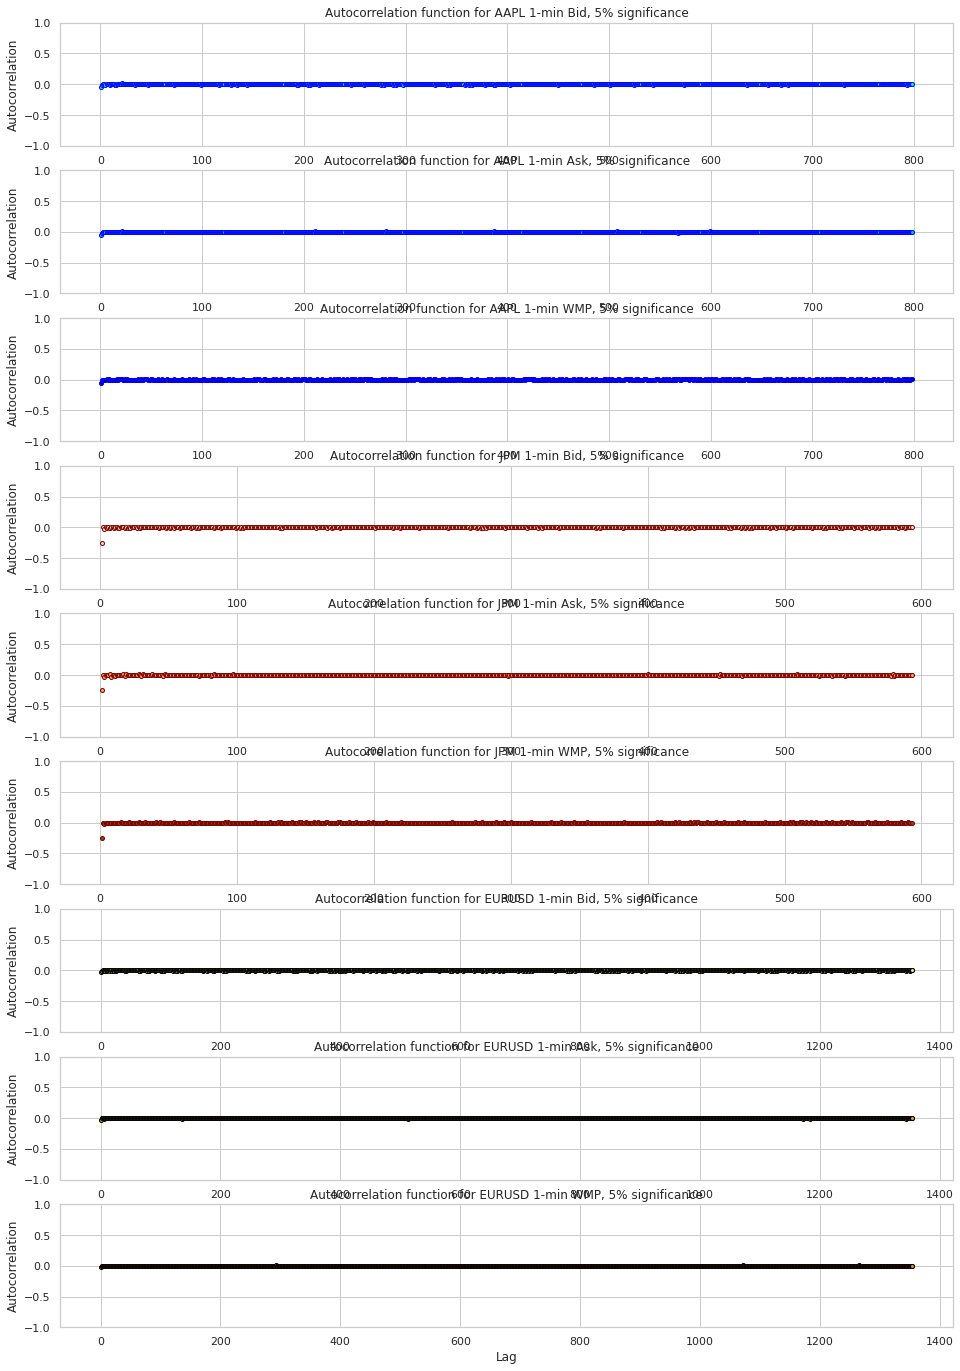

In [8]:
from hfdata import autocorr_gram
from scipy import stats
import statsmodels.api as sm
import scipy.stats as stats
sns.set(style="whitegrid", palette="muted")
i, j, k, m, n, p, q, r, s, n_lags_a, n_lags_j, n_lags_fx, sig = autocorr_gram(smF, lrFX)
fig, ax = plt.subplots(9, figsize=(16,24));
sm.graphics.tsa.plot_acf(i, lags=n_lags_a, alpha=sig, use_vlines=False, zero=False, fft=True, ax=ax[0], marker='o', markerfacecolor='cyan', markeredgecolor='blue', markersize=4);
sm.graphics.tsa.plot_acf(j, lags=n_lags_a, alpha=sig, use_vlines=False, zero=False, fft=True,  ax=ax[1], marker='o', markerfacecolor='deepskyblue', markeredgecolor='blue', markersize=4);
sm.graphics.tsa.plot_acf(k, lags=n_lags_a, alpha=sig, use_vlines=False, zero=False, fft=True,  ax=ax[2], marker='o', markerfacecolor='darkblue', markeredgecolor='blue', markersize=4);
sm.graphics.tsa.plot_acf(m, lags=n_lags_j, alpha=sig, use_vlines=False, zero=False, fft=True, ax=ax[3], marker='o', markerfacecolor='peachpuff', markeredgecolor='maroon', markersize=4);
sm.graphics.tsa.plot_acf(n, lags=n_lags_j, alpha=sig, use_vlines=False, zero=False, fft=True,  ax=ax[4], marker='o', markerfacecolor='sandybrown', markeredgecolor='maroon', markersize=4);
sm.graphics.tsa.plot_acf(p, lags=n_lags_j, alpha=sig, use_vlines=False, zero=False, fft=True,  ax=ax[5], marker='o', markerfacecolor='saddlebrown', markeredgecolor='maroon', markersize=4);   
sm.graphics.tsa.plot_acf(q, lags=n_lags_fx, alpha=sig, use_vlines=False, zero=False, fft=True, ax=ax[6], marker='o', markerfacecolor='khaki', markeredgecolor='black', markersize=4);
sm.graphics.tsa.plot_acf(r, lags=n_lags_fx, alpha=sig, use_vlines=False, zero=False, fft=True,  ax=ax[7], marker='o', markerfacecolor='goldenrod', markeredgecolor='black', markersize=4);
sm.graphics.tsa.plot_acf(s, lags=n_lags_fx, alpha=sig, use_vlines=False, zero=False, fft=True,  ax=ax[8], marker='o', markerfacecolor='darkorange', markeredgecolor='black', markersize=4);
ax[0].set(title="Autocorrelation function for AAPL 1-min Bid, 5% significance", ylabel="Autocorrelation");
ax[1].set(title="Autocorrelation function for AAPL 1-min Ask, 5% significance", ylabel="Autocorrelation");
ax[2].set(title="Autocorrelation function for AAPL 1-min WMP, 5% significance", ylabel="Autocorrelation");
ax[3].set(title="Autocorrelation function for JPM 1-min Bid, 5% significance", ylabel="Autocorrelation");
ax[4].set(title="Autocorrelation function for JPM 1-min Ask, 5% significance", ylabel="Autocorrelation");
ax[5].set(title="Autocorrelation function for JPM 1-min WMP, 5% significance", ylabel="Autocorrelation");
ax[6].set(title="Autocorrelation function for EURUSD 1-min Bid, 5% significance", ylabel="Autocorrelation");
ax[7].set(title="Autocorrelation function for EURUSD 1-min Ask, 5% significance", ylabel="Autocorrelation");
ax[8].set(title="Autocorrelation function for EURUSD 1-min WMP, 5% significance", xlabel="Lag", ylabel="Autocorrelation");
plt.show();

$\\[0.1in]$
Figure 8 plots sample autocorrelograms of squared returns. Again, 5% significance bands shown as darker grey zones. Autocorrelograms of squared returns may be used to diagnose volatility persistence. The panels for JPM and EURUSD in figure 8 are exemplary of the persistent nature of volatility. The squared returns have all autocorrelations significant for EURUSD and most for JPM WMP. Furthermore, the spared return autocorrelations are all positive for AAPL, EURUSD, and JPM WMP, which is highly unlikely to occur by chance. With squared returns I observe a marked smoothing of the autocorrelogram for SMP versus both Bid and Ask for JPM and EURUSD. The WURUSD WMP plot very clearly exhibits hyperbolic decay and a sharp hyperbolic decay is also evident in all of the other plots in the panel. Local maximums are evident at lags around midday and market close (approximately half way and three quarters of the way through the 04:00 to 16:00 observation window which, recall, covers extended hours).
$\\[0.1in]$

*Figure 8. Autocorrelograms for AAPL, JPM, EURUSD squared 1-minute samples; Bid, Ask, and Weighted Mid-Prices with 798, 593, and 1354 (i.e. 1 day equivalent) lags respectively. 5% significance bands shown as darker grey zones*
$\\[0.1in]$

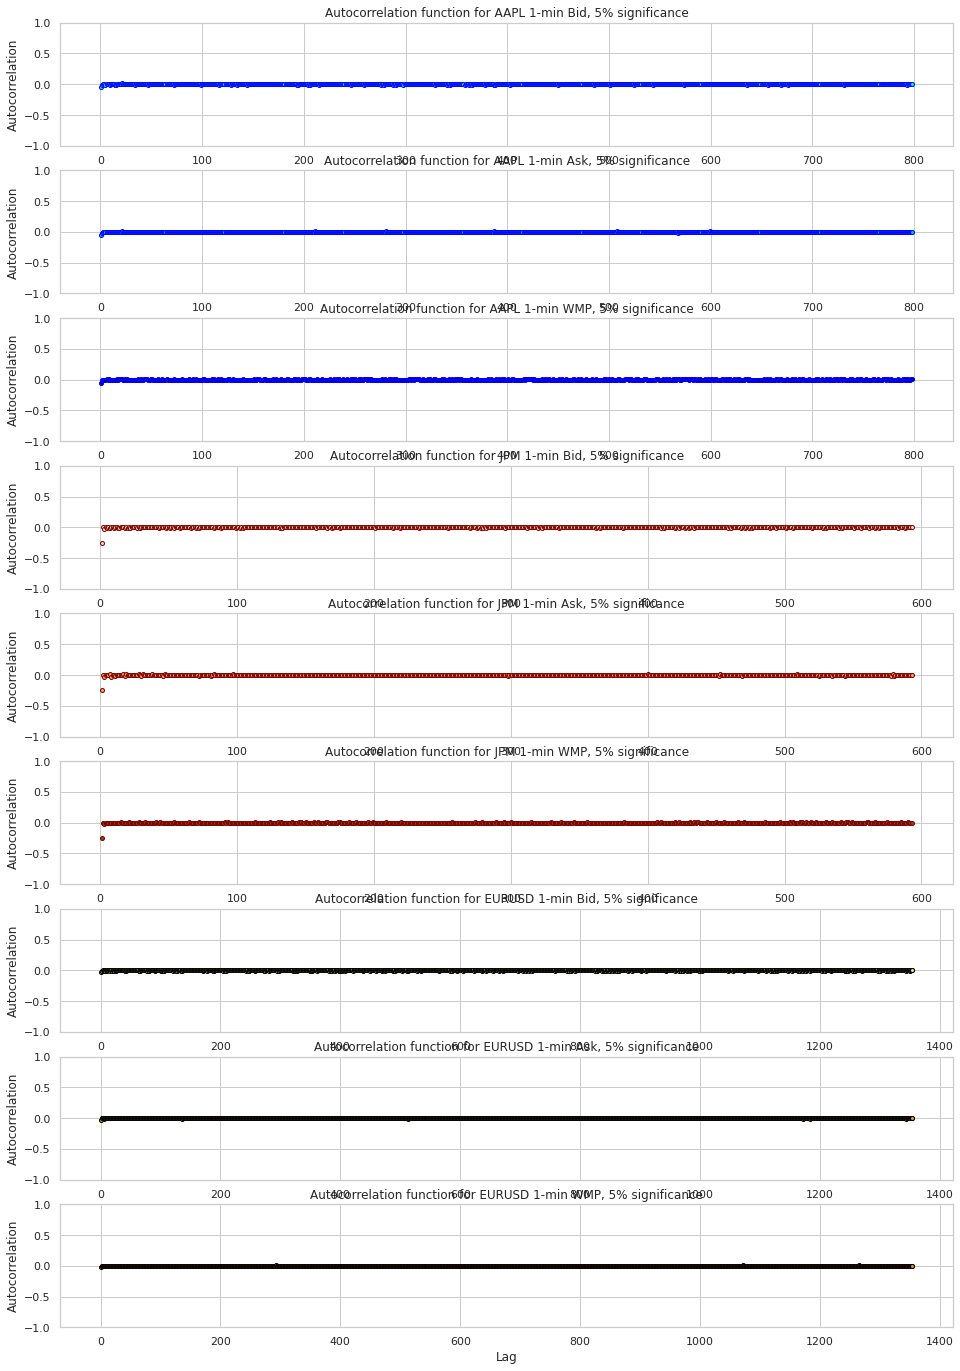

In [10]:
sns.set(style="whitegrid", palette="muted")
fig, ax = plt.subplots(9, figsize=(16,24));
sm.graphics.tsa.plot_acf(i, lags=n_lags_a, alpha=sig, use_vlines=False, zero=False, fft=True, ax=ax[0], marker='o', markerfacecolor='cyan', markeredgecolor='blue', markersize=4);
sm.graphics.tsa.plot_acf(j, lags=n_lags_a, alpha=sig, use_vlines=False, zero=False, fft=True,  ax=ax[1], marker='o', markerfacecolor='deepskyblue', markeredgecolor='blue', markersize=4);
sm.graphics.tsa.plot_acf(k, lags=n_lags_a, alpha=sig, use_vlines=False, zero=False, fft=True,  ax=ax[2], marker='o', markerfacecolor='darkblue', markeredgecolor='blue', markersize=4);
sm.graphics.tsa.plot_acf(m, lags=n_lags_j, alpha=sig, use_vlines=False, zero=False, fft=True, ax=ax[3], marker='o', markerfacecolor='peachpuff', markeredgecolor='maroon', markersize=4);
sm.graphics.tsa.plot_acf(n, lags=n_lags_j, alpha=sig, use_vlines=False, zero=False, fft=True,  ax=ax[4], marker='o', markerfacecolor='sandybrown', markeredgecolor='maroon', markersize=4);
sm.graphics.tsa.plot_acf(p, lags=n_lags_j, alpha=sig, use_vlines=False, zero=False, fft=True,  ax=ax[5], marker='o', markerfacecolor='saddlebrown', markeredgecolor='maroon', markersize=4);   
sm.graphics.tsa.plot_acf(q, lags=n_lags_fx, alpha=sig, use_vlines=False, zero=False, fft=True, ax=ax[6], marker='o', markerfacecolor='khaki', markeredgecolor='black', markersize=4);
sm.graphics.tsa.plot_acf(r, lags=n_lags_fx, alpha=sig, use_vlines=False, zero=False, fft=True,  ax=ax[7], marker='o', markerfacecolor='goldenrod', markeredgecolor='black', markersize=4);
sm.graphics.tsa.plot_acf(s, lags=n_lags_fx, alpha=sig, use_vlines=False, zero=False, fft=True,  ax=ax[8], marker='o', markerfacecolor='darkorange', markeredgecolor='black', markersize=4);
ax[0].set(title="Autocorrelation function for AAPL 1-min Bid, 5% significance", ylabel="Autocorrelation");
ax[1].set(title="Autocorrelation function for AAPL 1-min Ask, 5% significance", ylabel="Autocorrelation");
ax[2].set(title="Autocorrelation function for AAPL 1-min WMP, 5% significance", ylabel="Autocorrelation");
ax[3].set(title="Autocorrelation function for JPM 1-min Bid, 5% significance", ylabel="Autocorrelation");
ax[4].set(title="Autocorrelation function for JPM 1-min Ask, 5% significance", ylabel="Autocorrelation");
ax[5].set(title="Autocorrelation function for JPM 1-min WMP, 5% significance", ylabel="Autocorrelation");
ax[6].set(title="Autocorrelation function for EURUSD 1-min Bid, 5% significance", ylabel="Autocorrelation");
ax[7].set(title="Autocorrelation function for EURUSD 1-min Ask, 5% significance", ylabel="Autocorrelation");
ax[8].set(title="Autocorrelation function for EURUSD 1-min WMP, 5% significance", xlabel="Lag", ylabel="Autocorrelation");
plt.show();

$\\[0.1in]$
**High resolution autocorrelograms set up and discussion**

The autocorrelation of HF data has been shown to exhibit strong diurnal patterns (this is clearly demonstrated in some of the earliest HF literature, see for example Andersen & Bollerslev (1997, 1998)) and strong intraday patterns have been shown to 'contaminate' autocorrelations (for example, see Bollerslev, Sizova & Tanchen (2012)). Figures 9 and 10 show higher resolution log return autocorrelograms based upon 1-day (March 31st 2020) of data for JPM and AAPL. Figures 9 and 10 are also drawn to show diurnal patterns. In these figures a slow hyperbolic decay toward zero is clearly evident, particularly for AAPL. JPM shows a marked increase in autocorrelation at the start and the end of the day. Both of these diurnal patters are considerably less evident in the WMP compared to Bid and Ask.
$\\[0.1in]$

*Figure 9. High resolution view of 1-day (March 31st 2020) for AAPL, showing the effect of the Weighted Mid Price on autocorrelation and diurnal patterns*
$\\[0.1in]$

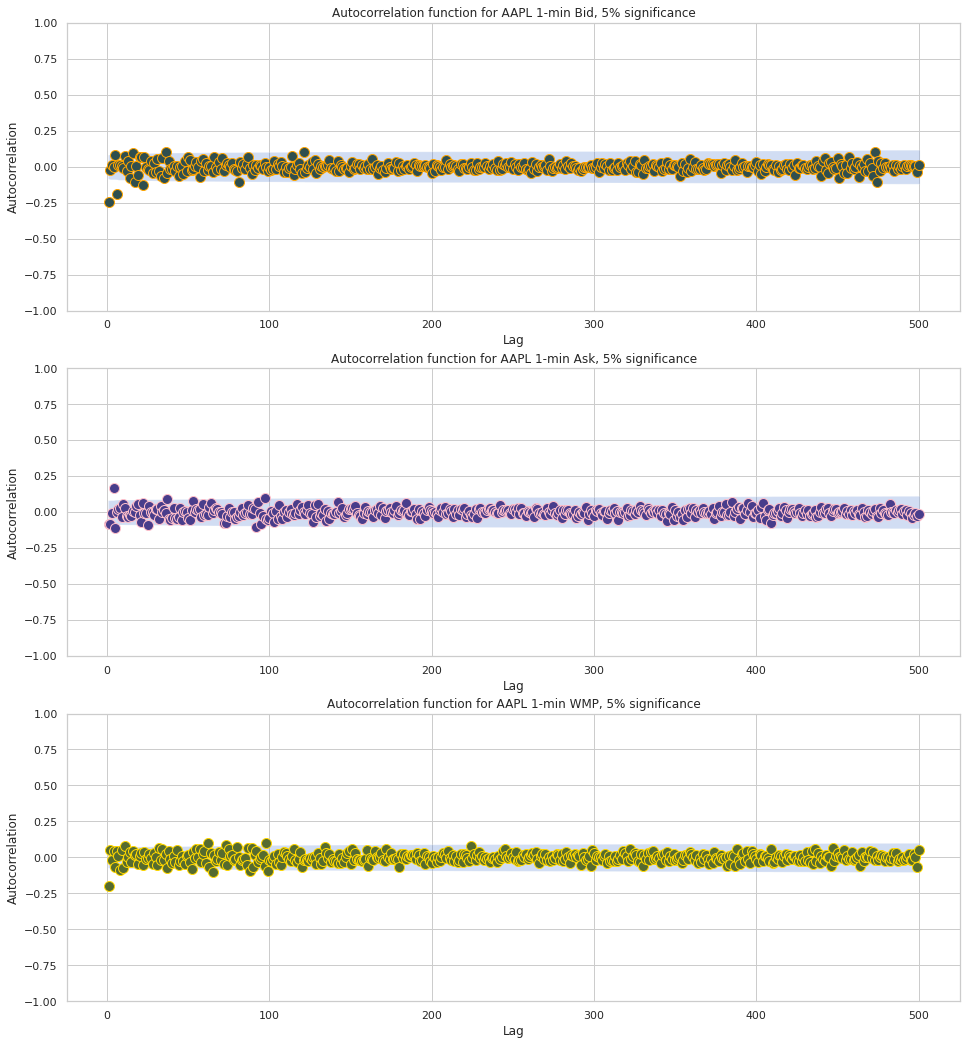

In [11]:
from hfdata import autocorr_highres
sns.set(style="whitegrid", palette="muted")
u, v, w, sig, zero, n_lags = autocorr_highres(smF)
fig, ax = plt.subplots(3, figsize=(16,18));
sm.graphics.tsa.plot_acf(u, lags=n_lags, alpha=sig, use_vlines=False, zero=False, fft=True, ax=ax[0], marker='o', markerfacecolor='darkslategrey', markeredgecolor='orange', markersize=10);
sm.graphics.tsa.plot_acf(v, lags=n_lags, alpha=sig, use_vlines=False, zero=False, fft=True,  ax=ax[1], marker='o', markerfacecolor='darkslateblue', markeredgecolor='pink', markersize=10);
sm.graphics.tsa.plot_acf(w, lags=n_lags, alpha=sig, use_vlines=False, zero=False, fft=True,  ax=ax[2], marker='o', markerfacecolor='darkolivegreen', markeredgecolor='gold', markersize=10);
ax[0].set(title="Autocorrelation function for AAPL 1-min Bid, 5% significance", xlabel="Lag", ylabel="Autocorrelation");
ax[1].set(title="Autocorrelation function for AAPL 1-min Ask, 5% significance", xlabel="Lag", ylabel="Autocorrelation");
ax[2].set(title="Autocorrelation function for AAPL 1-min WMP, 5% significance", xlabel="Lag", ylabel="Autocorrelation");
plt.show();

$\\[0.1in]$
*Figure 10. High resolution view of 1-day (March 31st 2020) for JPM, showing the effect of the Weighted Mid Price on autocorrelation and diurnal patterns*
$\\[0.1in]$

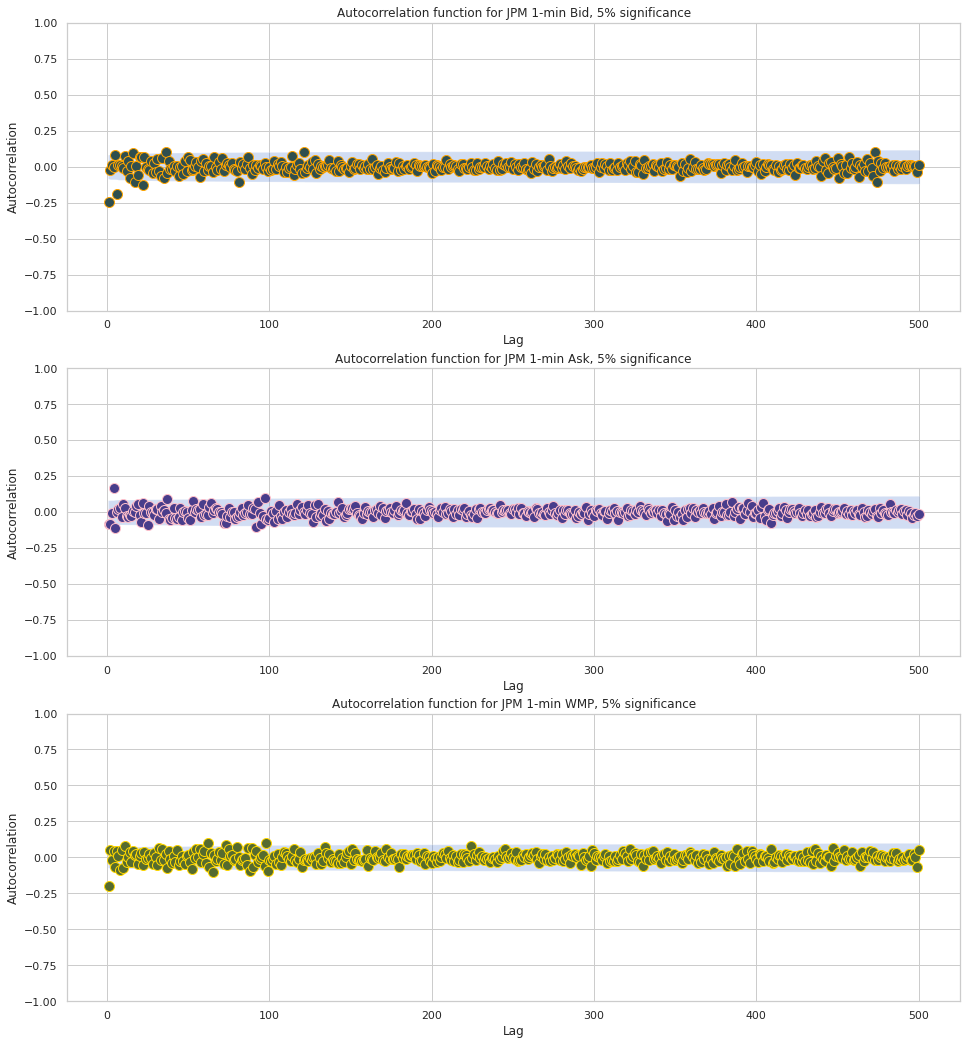

In [12]:
sns.set(style="whitegrid", palette="muted")
fig, ax = plt.subplots(3, figsize=(16,18));
sm.graphics.tsa.plot_acf(u, lags=n_lags, alpha=sig, use_vlines=False, zero=False, fft=True, ax=ax[0], marker='o', markerfacecolor='darkslategrey', markeredgecolor='orange', markersize=10);
sm.graphics.tsa.plot_acf(v, lags=n_lags, alpha=sig, use_vlines=False, zero=False, fft=True,  ax=ax[1], marker='o', markerfacecolor='darkslateblue', markeredgecolor='pink', markersize=10);
sm.graphics.tsa.plot_acf(w, lags=n_lags, alpha=sig, use_vlines=False, zero=False, fft=True,  ax=ax[2], marker='o', markerfacecolor='darkolivegreen', markeredgecolor='gold', markersize=10);
ax[0].set(title="Autocorrelation function for JPM 1-min Bid, 5% significance", xlabel="Lag", ylabel="Autocorrelation");
ax[1].set(title="Autocorrelation function for JPM 1-min Ask, 5% significance", xlabel="Lag", ylabel="Autocorrelation");
ax[2].set(title="Autocorrelation function for JPM 1-min WMP, 5% significance", xlabel="Lag", ylabel="Autocorrelation");
plt.show();

$\\[0.1in]$
Figure 11 shows log return autocorrelograms for the HF FX dataset, EURUSD 1-minute returns, with 1354 lags (approximately 1 day), and also shows the benchmark dataset DEXJPUS daily returns, with 50 and 500 lags respectively. If I contrast the 1-day plots for AAPL and JPM to figure 11, the FX autocorrelograms for EURUSD 1-minute returns and DEXJPUS daily returns, I observe that in both cases, 1 day and the full dataset, there is no obvious sign of hyperbolic decay, but significant autocorrelation is evident in all FX plots. There appear to be no obvious diurnal rhythms in the FX data.
$\\[0.1in]$

*Figure 11. Log return autocorrelograms for EURUSD 1-minute returns with 1354 lags (approximately 1 day), and DEXJPUS daily log returns with 50 and 500 lags respectively*
$\\[0.1in]$

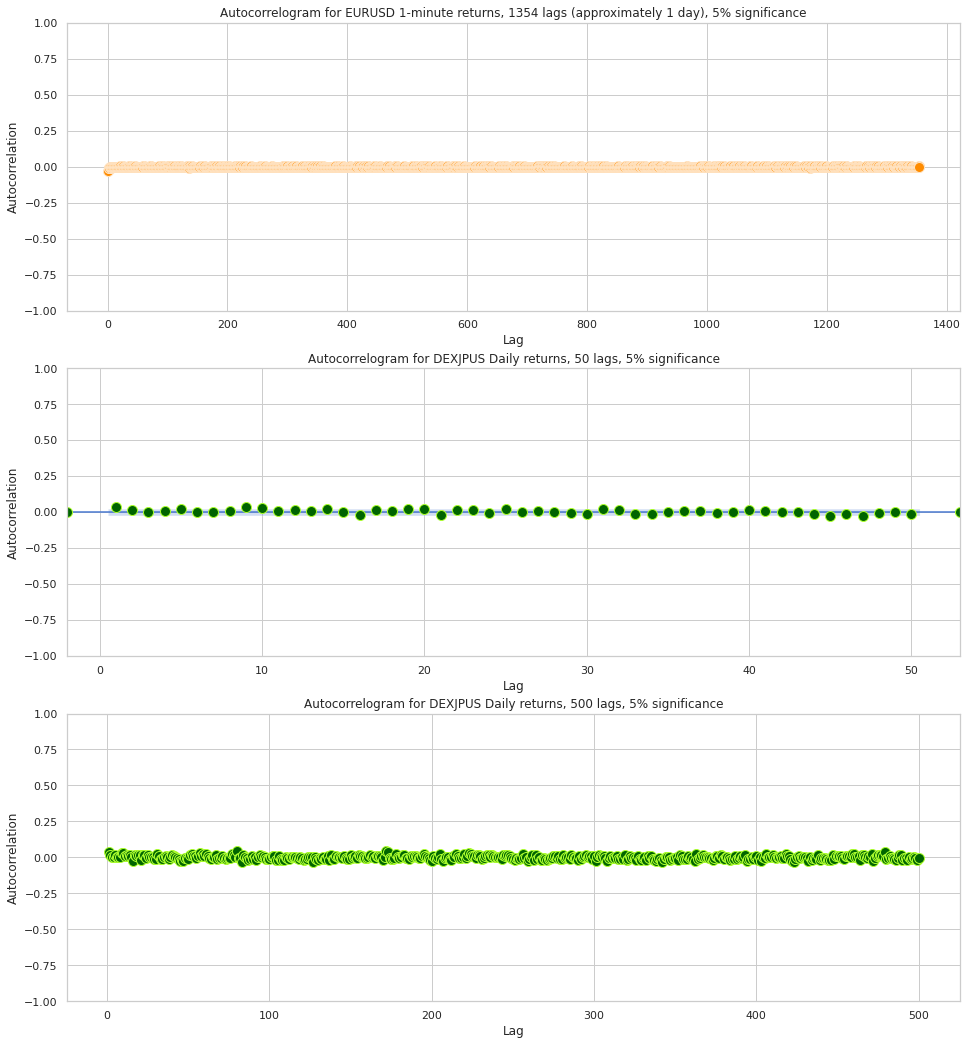

In [13]:
sns.set(style="whitegrid", palette="muted")
fig, ax = plt.subplots(3, figsize=(16,18));
sm.graphics.tsa.plot_acf(lrFX, lags=1354, alpha=0.05, use_vlines=False, zero=False, fft=True, ax=ax[0], marker='o', markerfacecolor='darkorange', markeredgecolor='bisque', markersize=10);
sm.graphics.tsa.plot_acf(dat2, lags=50, alpha=0.05, use_vlines=True, zero=False, fft=True, ax=ax[1], marker='o', markerfacecolor='darkgreen', markeredgecolor='greenyellow', markersize=10);
sm.graphics.tsa.plot_acf(dat2, lags=500, alpha=0.05, use_vlines=False, zero=False, fft=True, ax=ax[2], marker='o', markerfacecolor='darkgreen', markeredgecolor='greenyellow', markersize=10);
ax[0].set(title="Autocorrelogram for EURUSD 1-minute returns, 1354 lags (approximately 1 day), 5% significance", xlabel="Lag", ylabel="Autocorrelation");
ax[1].set(title="Autocorrelogram for DEXJPUS Daily returns, 50 lags, 5% significance", xlabel="Lag", ylabel="Autocorrelation");
ax[2].set(title="Autocorrelogram for DEXJPUS Daily returns, 500 lags, 5% significance", xlabel="Lag", ylabel="Autocorrelation");
plt.show();

$\\[0.1in]$
Table 7 shows the autocorrelations for APPL, JPM and EURUSD 1-minute log returns. Autocorrelations computed with 60 (i.e. approximately 1 hour) lags are shown in the top panel of table 7, with autocorrelations computed with approximately 1 day of lags (798, 593,  and 1354 for APPL, JPM and EURUSD respectively) shown in the bottom panel. The autocorrelations are computed thus:
$\\[0.1in]$

\begin{align}
    R_{ij} = \frac {C_{ij}} {\sqrt{C_{ii} \ast C_{jj}}}
\end{align}

$\\[0.1in]$
where $R_{ij}$ is a 2x2 correlation coefficient matrix and $C_{ij}$, $C_{ii}$, and $C_{jj}$ are covariance matrices. Let $X_t$ be one of one of the HF time series, AAPL, JPM, or EURUSD, so that $X = {\left[ x_1, x_2, ..., x_N \right]}^T$, then the covariance matrix element $C_{ij}$ is the covariance of $x_i$ and $x_j$, and the element $C_{ii}$ is the variance of $x_i$.
$\\[0.1in]$

*Table 7. Autocorrelations for AAPL, JPM, EURUSD 1-min Bid, Ask, and Weighted Mid-Prices with 60 (i.e. ~1 hour equivalent) and 798, 593, and 1354 (i.e. ~1 day equivalent) lags respectively*
$\\[0.1in]$

| | Bid | Ask | WMP |
| --- | --- | --- | --- |
| **1 hour (60 lags)** |  |
| Equities AAPL HF (1-min returns) | 0.0024242 | 0.00269481 | 0.00048721 |
| Equities JPM HF (1-min returns) | -0.00102395 | -0.00198531 | -0.00090568 |
| FX EURUSD HF (1-min returns) | 0.00236498 | 0.00226641 | 0.00262666 |
| **1 day (798, 593, 1354 lags) respectively** |  |
| Equities AAPL HF (1-min returns) | 0.00311272 | -0.00324153 | 0.00156785 |
| Equities JPM HF (1-min returns) | -0.00022127 | -0.00040657 | 0.00060687 |
| FX EURUSD HF (1-min returns) | -0.00037868 | -0.00026630 | -0.00026892 |


$\\[0.1in]$
I compute Ljung-Box (1978) Q-test (LBQ) statistics to test the significance of the autocorrelations. Table 8 reports LBQ statistics and associated p-values for AAPL, JPM, and EURUSD HF Bid, Ask, and Weighted Mid Price 1-minute log returns, respectively. The LBQ is a modified version of the Box-Pierce chi-square statistic, the latter being a simplified version of the former.  Similar assessment may also be conducted using a Breusch-Godfrey (1978) test or Durbin-Watson (1950, 1951) test. Instead of testing randomness at each distinct lag, it tests the autocorrelation based on a given number of lags $k = 0, 1, 2, ..., K$. I test the null hypothesis that my HF log returns are independently distributed and correlations are zero, thus:
$\\[0.1in]$

\begin{align}
    H_0: \rho \left( 1 \right) = 0, ..., \rho \left( k \right) = 0
\end{align}

$\\[0.1in]$
I compute the LBQ statistic thus:
$\\[0.1in]$

\begin{align}
    Q = n \left( n+2 \right) \sum^h_{k=1} \frac {\hat \rho^2_k} {\left( n - k \right)}
\end{align}

$\\[0.1in]$
where $n$ is the number of observations in my 1-minute log return datasets for AAPL, JPM, and EURUSD respectively, $\hat \rho_k$ is the $k$'th 1-minute log return autocorrelation, and $h$ is the number of lags tested, which is 10 for the results shown in table 8. Under $H_0$, $Q$ asymptotically follows a $\chi^2_{\left( h \right)}$. For significance level $\alpha$, the critical region for rejection of the null hypothesis of randomness is $Q > \chi^2_{1-\alpha, h}$, where $\chi^2_{1-\alpha, h}$ is the $1-\alpha$'th quantile of the chi-squared distribution with $h$ degrees of freedom.
$\\[0.1in]$

*Table 8. Ljung-Box Q statistics for AAPL, JPM, and EURUSD HF log returns*
$\\[0.1in]$

| | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 |
| --- | --- | --- | --- | --- | --- | --- | --- | --- | --- | --- |
| AAPL Bid |  |  |  |  |  |  |  |
| LBQ stat | 704.96 | 728.59 | 730.86 | 731.82 | 747.33 | 747.98 | 755.24 | 756.55 | 787.22 | 787.43 |
| p-value | 2e-155 | 6e-159 | 4e-158 | 4e-157 | 2e-159 | 2e-158 | 8e-159 | 4e-158 | 1e-163 | 1e-162 |
| AAPL Ask |  |  |  |  |  |  |
| LBQ stat | 665.85 | 708.50 | 709.49 | 710.35 | 730.36 | 730.73 | 731.85 | 735.16 | 742.11 | 743.71 |
| p-value | 7e-147 | 1e-154 | 1e-153 | 1e-152 | 1e-155 | 1e-154 | 9e-154 | 1e-153 | 6e-154 | 2e-153 |
| AAPL WMP |  |  |  |  |  |  |
| LBQ stat | 1049.5 | 1105.5 | 1106.0 | 1106.2 | 1135.3 | 1139.0 | 1140.3 | 1142.0 | 1165.2 | 1165.3 |
| p-value | 2e-230 | 8e-241 | 1e-239 | 3e-238 | 2e-243 | 7e-243 | 5e-242 | 3e-241 | 3e-245 | 4e-244 |
| JPM Bid |  |  |  |  |  |  |
| LBQ stat | 18154. | 18156. | 18269. | 18270. | 18333. | 18335. | 18351. | 18351. | 18352. | 18358. |
| p-value | 0.0000 | 0.0000 | 0.0000 | 0.0000 | 0.0000 | 0.0000 | 0.0000 | 0.0000 | 0.0000 | 0.0000 |
| JPM Ask |  |  |  |  |  |  |
| LBQ stat | 15276. | 15282. | 15451. | 15451. | 15464. | 15469. | 15548. | 15757. | 15768. | 15773. |
| p-value | 0.0000 | 0.0000 | 0.0000 | 0.0000 | 0.0000 | 0.0000 | 0.0000 | 0.0000 | 0.0000 | 0.0000 |
| JPM WMP |  |  |  |  |  |  |
| LBQ stat | 21659. | 21707. | 21889. | 21891. | 21912. | 21932. | 21934. | 21935. | 21972. | 21989. |
| p-value | 0.0000 | 0.0000 | 0.0000 | 0.0000 | 0.0000 | 0.0000 | 0.0000 | 0.0000 | 0.0000 | 0.0000 |
| FX Bid |  |  |  |  |  |  |
| LBQ stat | 589.98 | 617.03 | 654.22 | 654.59 | 708.73 | 710.41 | 713.06 | 723.17 | 725.56 | 734.59 |
| p-value | 2e-130 | 1e-134 | 1e-141 | 2e-140 | 6e-151 | 3e-150 | 1e-149 | 7e-151 | 2e-150 | 2e-151 |
| FX Ask |  |  |  |  |  |  |
| LBQ stat | 454.44 | 459.02 | 477.37 | 482.87 | 560.16 | 560.59 | 568.93 | 581.65 | 582.80 | 582.80 |
| p-value | 7e-101 | 2e-100 | 3e-103 | 3e-103 | 8e-119 | 7e-118 | 1e-118 | 2e-120 | 1e-119 | 8e-119 |
| FX WMP |  |  |  |  |  |  |
| LBQ stat | 487.45 | 523.82 | 562.86 | 568.35 | 620.16 | 623.49 | 624.36 | 630.58 | 631.39 | 637.14 |
| p-value | 5e-108 | 1e-114 | 1e-121 | 1e-121 | 8e-132 | 1e-131 | 1e-130 | 6e-131 | 3e-130 | 1e-130 |

$\\[0.1in]$
In all cases, Bid, Ask, and WMP for AAPL, JPM, and EURUSD, I reject the null hypothesis that the autocorrelation functions up to $k$ are zero. The p-values are highly significant. It is also interesting that the magnitudes of the LBQ statistics for WMP for AAPL and JPM are uniformly better than those of the Bid and Ask. My LBQ statistics test my null hypothesis that autocorrelations for lags $\{1, 2, ..., 10 \}$ approximate to $\mathcal{N} \left( 0, 1 \right)$, thus only 10 lags are tested. However, I observe in the autocorrelograms (1 day, i.e. several hundred lags) that the autocorrelations are relatively stable within channels and the LBQ statistics are also seen to stabilize quickly; 10 lags therefore is arguably representative.
$\\[0.1in]$

**Variance Ratios**

I compute Variance Ratios following Lo & Mackinlay (1988) and Campbell, Lo & MacKinlay (1997).  The Variance Ratio, $\mathrm{VR}$, of a $q$-period $\mathrm{WMP}$ returns series may be defined thus:
$\\[0.1in]$

\begin{equation}
    \mathrm{VR} \left( q \right) = \frac {\mathrm{Var} \left( \mathrm{WMP}_t, + \mathrm{WMP}_{t+1}, + ... + \mathrm{WMP}_{t-q+1} \right) / \, q} {\mathrm{Var} \left( \mathrm{WMP}_t \right)}
\end{equation}

$\\[0.1in]$
Lo & Mackinlay write the estimator for $\mathrm{VR} \left( q \right)$ thus:
$\\[0.1in]$

\begin{equation}
    \mathrm{VR} \left( q \right) = \frac {\hat \sigma^2 \left( q \right)} {\hat \sigma^2 \left( 1 \right)}
\end{equation}

$\\[0.1in]$
Where $\hat \sigma ^2 \left( 1 \right)$ is an unbiased estimator of 1-period returns thus: 
$\\[0.1in]$

\begin{equation}
    \hat \sigma ^2 \left( 1 \right) = \frac {1} {\mathrm{T} - 1} \sum^T_{t-1} \left( \mathrm{WMP}_t - \hat \mu \right) ^2
\end{equation}

$\\[0.1in]$
And where $\hat \sigma ^2 \left( q \right)$ is the estimator of the variance of the q-period returns, thus: 
$\\[0.1in]$

\begin{equation}
    \hat \sigma ^2 \left( q \right) = \frac {1} {m} \sum^T_{t-1} \left( \mathrm{ln} \frac {\mathrm{WMP}_t} {\mathrm{WMP}_{t-q}} - q \hat \mu \right) ^2
\end{equation}

$\\[0.1in]$
Each $\mathrm{VR}$ may therefore be thought of as the ratio of the $q$-times overlapping $\mathrm{WMP}$ return period versus the variance of the $\mathrm{WMP}$ return series multiplied by $q$.  These ratios are asymptotically equal to one for a random walk, less than one for a mean reverting series, and greater than one for a mean-averting series.
$\\[0.1in]$

Figure 12 shows Variance Ratio plots for AAPL, JPM, EURUSD Weighted Mid-Price returns and Unweighted Mid-Price returns, comparing the range of frequencies, $q$, from 1 minute to 1 day. This figure is quite time consuming to plot, so I provide the code below in markdown and refer to the associated source code on [my github](https://github.com/johncollinsai/post-high-frequency-data)
$\\[0.1in]$

*Figure 12. Variance Ratio plots for AAPL, JPM, EURUSD Weighted Mid-Price returns and Unweighted Mid-Price returns, comparing the range of frequencies, $q$, from 1 minute to 1 day*
$\\[0.1in]$

from hfdata import vr_list
sns.set(rc={'figure.figsize':(16,12)})
sns.set_style("whitegrid")
vr_list_a, vr_list_j, vr_list_fx, vr_a, vr_a_simple, vr_j, vr_j_simple, vr_fx, vr_fx_simple = vr_list(n_lags_fx, AAPL_lr, JPM_lr, lrFX, bigF, dfFX)
ax1 = plt.subplot(311);
ax1 = sns.lineplot(data=vr_list_a, palette="winter");
ax1.set(title="Variance Ratios for lags from 1-minute to 1-day for AAPL WMP and `unweighted` returns", ylabel="Variance Ratio");
ax1.legend(loc=7);
ax2 = plt.subplot(312);
ax2 = sns.lineplot(data=vr_list_j, palette="copper");
ax2.set(title="Variance Ratios for lags from 1-minute to 1-day for JPM WMP and `unweighted` returns", ylabel="Variance Ratio");
ax2.legend(loc=7);
ax3 = plt.subplot(313);
ax3 = sns.lineplot(data=vr_list_fx, palette="summer");
ax3.set(title="Variance Ratios for lags from 1-minute to 1-day for EURUSD WMP and `unweighted` returns", xlabel="q", ylabel="Variance Ratio");
ax3.legend(loc=7);

$\\[0.1in]$
Figure 12 shows that the 1 minute scaled variances are higher than lower frequency scaled variances, which is indicative of residual microstructure noise and consistent with the autocorrelograms reported above, for example figures 7 and 11.  Figure 12 also compares the Variance Ratios across the range of frequencies from 1 minute to 1 day to Variance Ratios computed over the same range of frequencies for simple unweighted means of the bid and ask for AAPL, JPM, and the EURUSD.  It can be observed that the residual microstructure noise is slightly higher in the simple unweighted returns series.
$\\[0.1in]$

Following Lo and MacKinlay (1988) I computed Variance Ratio test statistics at 1 minute, 5 minutes, 1 hour, and 1 day.  In all cases the null that the series is a pure random walk was rejected at the 1% significance level, with very low p-values returned by all tests. Negative values for the test statistics indicated some residual autocorrelation in both the $\mathrm{WMP}$ returns and the simple unweighted returns.
$\\[0.1in]$

# Mitigating microstructure noise

Data analysis clearly shows residual microstructure noise in the HF time series. I use a WMP to mitigate microstructure noise and my primary justification for use of the WMP is empirical, not theoretical. Trading via limit orders and market orders has become the dominant form of trading in most exchanges around the world, whether these are pure electronic limit order markets, or hybrid markets in which limit order traders are in competition with floor traders, specialists, or dealers (see for example Roşu (2019, 2009)). The order book matches orders on a price-time priority and keeps track of all previously submitted buy and sell limit orders. Though all orders are anonymous, I (along with the much broader universe of market participants) may see the orders at each price level, and thus have information about the instantaneous supply and demand in the market. With the benefit of this information, I might quite naturally choose to build a mid-price, thus:
$\\[0.1in]$

\begin{align}
    M = \frac {1} {2} \left( P^a + P^b \right)
\end{align}

$\\[0.1in]$
where $P^b$ is the best (that is, the highest) Bid price and $P^a$ is the best (lowest) ask price. This measure is broadly accepted as a notion of 'fair' price by academics and practitioners.
$\\[0.1in]$

An important effect of the transparency of the limit order book is that the volume at the best Bid and Ask prices provides a strong signal of the next price move. To improve upon the mid-price therefore, I may choose instead to follow a widely used method among practitioners, who also pay close attention to the weighted mid-price (WMP):
$\\[0.1in]$

\begin{align}
    \mathrm{WMP} = I P^a + \left( 1 - I \right) P^b
\end{align}

$\\[0.1in]$
where the weight I is given by the imbalance:
$\\[0.1in]$

\begin{align}
    I = \frac {Q^b} {Q^b + Q^a}
\end{align}

$\\[0.1in]$
where $Q^b$ is the bid size (that is, total volume at the best bid) and $Q^a$ is the ask size.
$\\[0.1in]$

The volume at the best Bid and Ask prices has been shown to be a strong predictor of the next traded price. This feature of imbalances has been reported by, for example, Stoikov (2020), Dacorogna (2018), Lehalle & Mounjid (2018), Stoikov & Waeber (2016), Gould & Bonart (2015), Lehalle & Laruelle (2014), Lipton, Pesavento & Sotiropoulos (2013), Burlakov, Kamal & Salvadore (2012), Robert & Rosenbaum (2012), Avellaneda, Reed & Stoikov (2011), and Gatheral & Oomen (2010)).
$\\[0.1in]$

WMP is widely used in practice (see for example Stoikov (2020), Dacorogna (2018), Lehalle & Mounjid (2018), and Gatheral & Oomen (2010)), and has also been used by researchers (Ait-Sahalia, Mykland & Zhang (2010), for example, compute log-returns from quotes using a bid-ask midpoint, weighted by the respective depth of the two sides). The typical explanation (from a practitioner) for use of WMP is that, the larger quantity of shares on the Bid than on the Ask typically observed, indicates greater buying pressure, and therefore the "true" price is closer to the Ask than to the Bid. Thus, it follows, and is a reasonable assumption, that market buy/sell orders arriving are likely to be roughly matched and thus use the quantities at the Bid and Ask to adjust for the concomitant movement in the price. It is this mechanism that negates or reduces Bid-Ask bounce.
$\\[0.1in]$

# Conclusion

***In this post I have described the steps taken to thoroughly cleanse high frequency equities and FX data for subsequent use with deep learning and reinforcement learning methods. I have described important characteristics of the resultant datasets, using volatility prediction as a problem setting. I hope this post also provides useful insights regarding the importance of good data preparation for any modelling exercise.***

# References

Ait-Sahalia, Y. (1996). Nonparametric pricing of interest rate derivative securities. Econometrica, Vol. 64, No. 3, 527–60.
$\\[0.05in]$

Ait-Sahalia, Y. (2002). Maximum likelihood estimation of discretely sampled diffusions: A closed-form approximation approach. Econometrica, Vol. 70, No. 1, 223-262.
$\\[0.05in]$

Ait-Sahalia, Y. & Lo, A.W. (1998). Nonparametric estimation of state-price densities implicit in asset prices. The Journal of Finance, Vol LIII, No. 2, April 1998, 499-547.
$\\[0.05in]$

Aït-Sahalia, & Mancini, L. (2008). Out of sample forecasts of quadratic variation. Journal of Econometrics, 147, 17–33.
$\\[0.05in]$

Ait-Sahalia Y. & Mykland P.A. (2009). Estimating volatility in the presence of market microstructure noise: A review of the theory and practical considerations. In Mikosch, T., Kreiß, J.P., Davis, R. & Andersen, T. (Eds) Handbook of Financial Time Series. Springer, Berlin, Heidelberg
$\\[0.05in]$

Ait-Sahalia, Y., Mykland, P. A. & Zhang, l. (2005).  How often to sample a continuous- time process in the presence of market microstructure noise.  Review of Financial Studies, Vol. 18, No. 2, 351-416.
$\\[0.05in]$

Ait-Sahalia, Y., Mykland, P. A. & Zhang, l. (2011).  Ultra high frequency volatility estimation with dependent microstructure noise. Journal of Econometrics. Volume 160, Issue 1, January 2011, 160-175.
$\\[0.05in]$

Ait-Sahalia, Y. & Jacod, J. (2012). Analyzing the spectrum of asset returns: Jump and volatility components in high frequency data. Journal of Economic Literature 2012, 50(4), 1007-1050.
$\\[0.05in]$

Ait-Sahalia, Y. & Jacod, J. (2014). High-frequency financial econometrics. Princeton University Press, Princeton, NJ.
$\\[0.05in]$

Ait-Sahalia, Y. & Yu, J.L. (2009). High frequency market microstructure noise estimates and liquidity measures. The Annals of Applied Statistics, Vol. 3, No. 1, 422–457
$\\[0.05in]$

Alausa, W. B. (2014). Dynamic futures hedging with a vector error correction Markov Switching Multifractal model. Available at SSRN: https://ssrn.com/abstract=2523019
$\\[0.05in]$

Almgren, R. (2009). Optimal trading with stochastic liquidity and volality. SIAM Journal of Financial Mathematics, Vol 3. 163-181.
$\\[0.05in]$

Amihud, Y., Mendelson, H. & Pedersen, L. H. (2005). Liquidity and asset prices. Foundations and Trends in Finance, 1, 269–364.
$\\[0.05in]$

Andersen, T.G. & Benzoni, L. (2009). Realized Volatility. In Andersen, T.G., et al. Eds. Handbook of Financial Time Series, Springer Verlag.
$\\[0.05in]$

Andersen, T.G., & Bollerslev, T. (1997). Intraday periodicity and volatility persistence in financial markets. Journal of Empirical Finance, Vol. 4, Issue 2-3, 115-158.
$\\[0.05in]$

Andersen, T.G., & Bollerslev, T. (1998).  Answering the skeptics: yes, standard volatility models do provide accurate forecasts.  International Economic Review 39, 885-905.
$\\[0.05in]$

Andersen, T.G., Bollerslev, T., Christoffersen, P.F. & Diebold, F.X. (2006).  Volatility and Correlation Forecasting.  In Elliot, G., Granger, C.W.J. & Timmerman, A. (Eds.), Handbook of Economic Forecasting Vol 1, 777-878.  Amsterdam: North Holland.
$\\[0.05in]$

Andersen, T.G., Bollerslev, T., Christoffersen, P.F. & Diebold, F.X. (2011).  Financial Risk Measurement for Financial Risk Management. In Constantinedes, G., Harris, M. & Stulz, R. (Eds.), Handbook of the Economics of Finance. Elsevier Inc..
$\\[0.05in]$

Andersen, T.G., Bollerslev, T. & Diebold, F.X. (2005). Roughing it Up: Including Jump Components in the Measurement, Modeling and Forecasting of Return Volatility. NBER Working Paper No. w11775.
$\\[0.05in]$

Andersen, T.G., Bollerslev, T., & Diebold, F.X. (2010). Parametric and nonparametric volatility measurement. In Ait-Sahalia, Y. & Hansen, L.P. (Eds.), Handbook of Financial Econometrics: Volume 1, Tools and Techniques, 67–137. Amsterdam and Boston: Elsevier, North-Holland.
$\\[0.05in]$

Andersen, T.G., Bollerslev, T., Diebold, F.X., Labys, P. (2001). The distribution of exchange rate volatility. Journal of the American Statistical Association, 96:453, 42-55.
$\\[0.05in]$

Andersen, T.G., Bollerslev, T., Diebold, F.X., Labys, P. (2003). Modeling and Forecasting Realized Volatility. Econometrica, 71, 579-625.
$\\[0.05in]$

Andersen, T.G., Bollerslev, T. & Lange, S. (1999). Forecasting financial market volatility: sample frequency vis-a-vis forecast horizon. Journal of Empirical Finance, Vol. 6, No. 5, 457-77.
$\\[0.05in]$

Andersen, T.G., Bollerslev, T. & Meddahi, N. (2011). Realized volatility forecasting and market microstructure noise. Journal of Econometrics, 160 (2011), 220-234
$\\[0.05in]$

Andersen, T.G., Thyrsgaard, M. & Todorov, V. (2018). Time-varying periodicity in intraday volatility. Journal of the American Statistical Association, Vol. 114, 2019, Issue 528, 1695-1707.
$\\[0.05in]$

Anderson, R.M., Eom, K.S., Hahn, S.B. & Park, J.H. (2012). Sources of stock return autocorrelation. Working Paper.
$\\[0.05in]$

Andersson, M., Ang, A., Haugerud, P., Ithurbide P., & Orr, A. (2012). Long-term investing: An optimal strategy in short-term oriented markets. Organized by the Committee on Global Thought at Columbia University & the Sovereign Wealth Fund Research Initiative. Available at https://cgt.columbia.edu/ 
$\\[0.05in]$

Ang, A., and Bekaert, G. (2007).  Stock return predictability: Is it there?  Review of Financial Studies 20(3), 651-707.
$\\[0.05in]$

Avellaneda, M., Reed, J. & Stoikov, S. (2011). Forecasting prices from level-1 quotes in the presence of hidden liquidity. Algorithmic Finance, 1
$\\[0.05in]$

Bachelier, L. (1900). Théorie de la spéculation. Annales Scientifiques de l’École Normale Supérieure 3: 21–86.
$\\[0.05in]$

Baillie, R., Bollerslev, T. & Mikkelsen, M.O. (1996). Fractionally integrated generalized autoregressive conditional heteroscedasticity.  Journal of Econometrics 74 (1996), 3–30.
$\\[0.05in]$

Ball, C. (1988). Estimation bias induced by discrete security prices. Journal of Finance, 43, 841-865.
$\\[0.05in]

Bandi, F. & Russel, J. (2005). Separating Microstructure Noise from Volatility. Journal of Financial Economics, 79, 655-692.
$\\[0.05in]$

Barndorff-Nielsen, O.E., Hansen, P.R., Lunde, A. & Shephard, N. (2007). Sub-sampling realised kernels. Available at SSRN: https://ssrn.com/abstract=927483
$\\[0.05in]$

Barndorff-Nielsen, O.E., Hansen, P.R., Lunde, A. & Shephard, N. (2008). Designing realized kernels to measure the ex-post variation of equity prices in the presence of noise. Econometrica, 76, 1481–1536.
$\\[0.05in]$

Barndorff-Nielsen, O.E., Hansen, P.R., Lunde, A. & Shephard, N. (2009). Realized kernels in practice: Trades and quotes. The Econometrics Journal, Vol. 12, No. 3 (2009), 1-32.
$\\[0.05in]$

Barndorff-Nielsen, O.E., Kinnebrock, S. & Shephard, N. (2010). Measuring downside risk – realised semivariance. In Bollerslev, T., Russell, J. & Watson, M. (Eds.), Volatility and Time Series Econometrics: Essays in Honor of Robert F. Engle. Oxford University Press.
$\\[0.05in]$

Barndorff-Nielsen, O.E. & Shephard, N. (2001). Non-Gaussian Ornstein-Uhlenbeckbased models and some of their uses in financial economics. Journal of the Royal Statistical Society B 63: 167–241.
$\\[0.05in]$

Barndorff-Nielsen, O.E. & Shephard, N. (2002). Econometric analysis of realised volatility and its use in estimating stochastic volatility models. Journal of the Royal Statistical Society, Vol 64, Issue 2, 253-280.
$\\[0.05in]$

Barndorff-Nielsen, O.E. & Shephard, N. (2003). Realized power variation and stochastic volatility models. Bernoulli 9: 243–65.
$\\[0.05in]$

Barndorff-Nielsen, O.E. & Shephard, N. (2004). Power and bipower variation with stochastic volatility and jumps. Journal of Financial Econometrics 2(1): 1–37.
$\\[0.05in]$

Barndorff-Nielsen, O.E. & Shephard, N. (2006). Econometrics of testing for jumps in financial econometrics using bipower variation. Journal of Financial Econometrics 4: 1–30.
$\\[0.05in]$

Barndorff-Nielsen, O.E. & Shephard, N., (2007). Variation, jumps, market frictions and high frequency data in financial econometrics. In: Blundell, R., Torsten, P. & Newey, W.K. (Eds.). Advances in Economics and Econometrics. Theory and Applications. In: Econometric Society Monographs, Cambridge University Press, Cambridge.
$\\[0.05in]$

Bartlett, M.S. (1946). On the Theoretical Specification and Sampling Properties of Autocorrelated Time-Series. Supplement to the Journal of the Royal Statistical Society. Vol. 8, No. 1, 27-41
$\\[0.05in]$

Bartlett, R.P. & McCrary, J. (2019). How rigged are stock markets? Evidence from microsecond timestamps. Journal of Financial Markets. Vol. 45, September 2019, 37-60.
$\\[0.05in]$

Bates, D. (2012).  U.S. stock market crash risk, 1926-2010.  Journal of Financial Economics 105, 229–259
$\\[0.05in]$

Bauwens, L., Laurent, S., & Rombouts, J. V. K. (2006). Multivariate GARCH models: A survey. Journal of Applied Econometrics 21, 79-109.
$\\[0.05in]$

Beran, J. (1994). Statistics for long-memory processes. Monographs on Statistics and Applied Probability, Chapman & Hall/CRC, London.
$\\[0.05in]$

Blattberg, R. C. & Gonedes, N. J. (1974). A comparison of the Student and stable distributions as statistical models of stock prices. Journal of Business, 47, 244–80.
$\\[0.05in]$

Bollerslev, T. (1986). Generalized autoregressive conditional heteroskedasticity. Journal of Econometrics 31: 307–27.
$\\[0.05in]$

Bollerslev, T. (2010). Glossary to ARCH (GARCH). In Volatility and Time Series Econometrics: Essays in Honour of Robert F. Engle. Eds. Bollerslev, T., Russell, J.R., & Watson, M. Oxford University Press, Oxford, UK.
$\\[0.05in]$

Bollerslev, T., Engle, R. & Nelson, D. (1994). Arch Models. In Engle, R. & McFadden, D. L. (Eds.). Handbook of econometrics, Vol. 4. Amsterdam: North-Holland, 2959–3038.
$\\[0.05in]$

Bollerslev, T., Hood, B., Huss, J., Pedersen, L.H. (2017). Risk Everywhere: Modeling and Managing Volatility. Available at SSRN: https://ssrn.com/abstract=2722591
$\\[0.05in]$

Bollerslev, T., Li, J. & Xue, Y. (2018). Volume, volatility, and public news announcements. Review of Economic Studies (2018), 85, 2005-2041.
$\\[0.05in]$

Bollerslev, T., Litvinova, J. & Tauchen, G. (2006). Leverage and volatility feedback effects in high-frequency data. Journal of Financial Econometrics, 4(3), 353-384.
$\\[0.05in]$

Bollerslev, T., Patton, A.J., & Quaedvlieg, R. (2016). Exploiting the errors: A simple approach for improved volatility forecasting. Journal of Econometrics, 192, 1–18.
$\\[0.05in]$

Bollerslev, T., Patton, A.J., & Quaedvlieg, R. (2018). Modeling and forecasting (un)reliable realized covariances for more reliable financial decisions. Journal of Econometrics, 207, 71–91.
$\\[0.05in]$

Bollerslev, T., Sizova, N. & Tauchen, G. (2012). Volatility in equilibrium: Asymmetries and dynamic dependencies. Review of Finance, Vol. 16, 31–80.
$\\[0.05in]$

Bollerslev, T., Tauchen, G. and Zhou, H. (2008). Expected stock returns and variance risk premia. Working Paper.
$\\[0.05in]$

Bollerslev, T. & Todorov, V. (2011). Estimation of jump tails. Econometrica, 79, 1727–1783.
$\\[0.05in]$

Box, G. E. P., Jenkins, G. M. & Reinsel, G. C. (1994). Time series analysis: forecasting and control (3 Ed.). Upper Saddle River, NJ. Prentice–Hall. 
$\\[0.05in]$

Brownlees, C.T. & Gallo, G.M. (2006). Financial econometric analysis at ultra-high frequency: data handling concerns. Universita di Firenze, Dipartimento di Statistica G. Parenti Working Paper No. 2006-3. Available at SSRN.
$\\[0.05in]$

Brownlees, C.T., Nualart, E. & Sun, Y.C. (2019). On the estimation of integrated volatility in the presence of jumps and microstructure noise. Available at SSRN: https://ssrn.com/abstract=2791342
$\\[0.05in]$

Burlakov, Y., Kamal, M. & Salvadore, M. (2012). Optimal limit order execution in a simple model for market microstructure dynamics. Available at
https://papers.ssrn.com/sol3/papers.cfm?abstract id=2185452.
$\\[0.05in]$

Calderhead, B. & Griveau-Billion, T. (2020). A dynamic Bayesian model for interpretable decompositions of market behaviour. arXiv:1904.08153v3
$\\[0.05in]$  

Calvet, L.E. & Fisher, A.J. (2001).  Forecasting multifractal volatility, Journal of Econometrics 105, 27-58.
$\\[0.05in]$

Calvet, L.E. & Fisher, A.J. (2002).  Multifractality in asset returns: Theory and Evidence. The Review of Economics and Statistics, Vol. LXXXIV, No. 3, 381-406
$\\[0.05in]$

Calvet, L.E. & Fisher, A.J. (2004).  How to forecast long-run volatility: Regime switching and the estimation of multifractal processes.  Journal of Financial Econometrics 2 (1), 49-83.
$\\[0.05in]$

Calvet, L.E. & Fisher, A.J. (2007).  Multi-frequency news and stock returns.  Journal of Financial Economics 86 (1), 178-212. 
$\\[0.05in]$

Calvet, L.E. & Fisher, A.J. (2008a).  Multifractal Volatility Theory, Forecasting, and Pricing.  Elsevier, Academic Press.
$\\[0.05in]$

Calvet, L.E. & Fisher, A.J. (2008b).  Multi-frequency jump-diffusions: An equilibrium approach, Journal of Mathematical Economics 44 (2), 207-226.
$\\[0.05in]$

Calvet, L.E. & Fisher, A.J. (2013).  Extreme Risk and Fractal Regularity in Finance. In Carfì, D., Lapidus, M.L., Pearse, E.P.J. & van Frankenhuijsen, M. (Eds.), Fractal Geometry and Dynamical Systems in Pure and Applied Mathematics II: Fractals in Applied Mathematics, Contemporary Mathematics, Volume 601.
$\\[0.05in]$

Calvet, L.E. Fisher, A.J. & Thompson, S. (2006).  Volatility co-movement: A multi-frequency approach, Journal of Econometrics 131, 179-215.
$\\[0.05in]$

Calvet, L.E., Fearnley, M., Fisher, A.J. & Leippold, M. (2015).  What is beneath the surface? Option pricing with multi-frequency latent states, Journal of Econometrics, 187 (2), 498-511. 
$\\[0.05in]$

Campbell, J.Y. & Hentschel, L. (1992). No news is good news: an asymmetric model of changing volatility in stock returns. Journal of Financial Economics, 31, 281–318.
$\\[0.05in]$

Campbell, J.Y., Lo, A.W. & MacKinlay, A.C. (1997). The Econometrics of Financial Markets. Princeton University Press, Princeton, New Jersey
$\\[0.05in]$

Carrasco, M., Chernozhukov, V., Goncalves, S. and Renault, E. (2015).  High dimensional problems in econometrics, Editorial.  Journal of Econometrics, 186 (2015), 277-279
$\\[0.05in]$

Cho, D., & Frees, E. (1988). Estimating the volatility of discrete stock prices. Journal of Finance, 43, 451-466.
$\\[0.05in]$

Christodoulakis, G.A. & Satchell, S.E. (1988). Hashing GARCH; A resassessment of volitility forecast and performance. In Forecasting volatility in the finacial markets. Knight, J. & Satchell, S.E., Eds. Butterworth Heinemann, Ch. 6, 168-92.
$\\[0.05in]$

Clements, M., Galvao, A., & Kim, J. (2008). Quantile forecasts of daily exchange rate returns from forecasts of realized volatility. Journal of Empirical Finance, Vol. 15, Issue 4, 729-750.
$\\[0.05in]$

Cootner, P.H. (1964). The random character of stock market prices. Cambridge, Mass. and London: MIT Press.
$\\[0.05in]$

Dacorogna, M.M. (2018). What can we learn from high frequency data in finance - 30 years later? ETH Risk-Center Seminar Series, Zurich.
$\\[0.05in]$

Dacorogna, M.M., Gencay, R., Muller, U.A., Olsen, R.B., Pictet, O.V. (1993). A geographical model for the daily and weekly seasonal volatility in the foreign exchange market. Journal of International Money and Finance, 12, 413–38.
$\\[0.05in]$

Dacorogna, M.M., Gencay, R., Muller, U.A., Olsen, R.B., Pictet, O.V. (2001). An introduction to high frequency finance. Academic Press, San Diego.
$\\[0.05in]$

Delbaen, F. & Schachermayer, W. (1994). A general version of the fundamental theorem of asset pricing. Mathematische Annalen 300, 463–520.
$\\[0.05in]$

Delattre, S. & Jacod, J. (1997). A central limit theorem for normalized functions of the increments of a diffusion process, in the presence of round-off errors. Bernoulli (3), 1-28.
$\\[0.05in]$

De Luca, G. (2006). Forecasting volatility using high-frequency data. Statistica Applicata, Vol. 18, n. 2, 2006, 407-422
$\\[0.05in]$

Deo, R., Hurvich, C. & Lu, Y. (2006). Forecasting realized volatility using a long-memory stochastic volatility model: estimation, prediction and seasonal adjustment. Journal of Econometrics, 131, 29–58
$\\[0.05in]$

Easley, D., Engle, R., O'Hara, M. & Wu, L. (2008). Time-varying arrival rates of informed and uninformed trades. Journal of Financial Econometrics, 2008, 171-207.
$\\[0.05in]$

Elliott, G. & Timmermann, A. (2013).  Handbook of Economic Forecasting Vol 2A.  Amsterdam: North Holland.
$\\[0.05in]$

Engle, R. (1982). Autoregressive conditional heteroscedasticity with estimates of the variance of United Kingdom inflation. Econometrica 50: 987–1007.
$\\[0.05in]$

Engle, R. (2000).  The econometrics of ultra high frequency data.  Econometrica 68, 1: 1–22.
$\\[0.05in]$

Engle, R. (2002). New frontiers for ARCH models. Journal of Applied Econometrics, 17: 425-446.
$\\[0.05in]$

Engle, R. (2004). Risk and volatility: Econometric models and financial practice. The American Economic Review, Vol. 94, No. 3, 405-420.
$\\[0.05in]$

Engle, R., Focardi, S., and Fabozzi, F. (2008).  ARCH/GARCH models in applied financial econometrics .  Handbook Series in Finance, Ed. Fabozzi, F.J., John Wiley and Sons.
$\\[0.05in]$

Engle, R. & Sun, Z. (2005). Forecasting volatility using tick by tick data.  Unpublished paper.
$\\[0.05in]$

Engle, R. & Sun, Z. (2007). When is noise not noise – a microstructure estimate of realized volatility.  Unpublished paper.
$\\[0.05in]$

Fielitz, B. D. & Rozelle, J. P. (1982). Stable distributions and mixtures of stable distributions hypotheses for common stock returns. Journal of the American Statistical Association, 78, 28–36.
$\\[0.05in]$

Figlewski, S. (1997). Forecasting volatility. In Finance, Markets, Instruments. NYU, Salomon Center, 6:1, 1-88.
$\\[0.05in]$

Figueroa, J.E. & Wu, B. (2020). Kernel estimation of spot volatility with microstructure noise using pre-averaging. arXiv:2004.01865v1.
$\\[0.05in]$

Friendly, M. (2002). Corrgrams: Exploratory displays for correlation matrices. The American Statistician. Taylor & Francis. 56 (4): 316–324. 
$\\[0.05in]$

Garcia, R. & Meddahi, N. (2006). Comment on realized variance and market microstructure noise. Journal of Business and Economic Statistics, 24, 184–191.
$\\[0.05in]$

Garcia, R. & Tsafack, G. (2011).  Dependence structure and extreme comovements in international equity and bond markets.  Journal of Banking & Finance 35 (2011) 1954-1970.
$\\[0.05in]$

Garman, M.B. & Klass, M.J. (1980). On the estimation of security price volatilities from historical data.  The Journal of Business, Vol. 53, No. 1, Jan. 1980, 67-78
$\\[0.05in]$

Gatheral, J. & Oomen, R.C.A. (2010). Zero-intelligence realized variance estimation. Finance and Stochastics, 14 (2), 249–83.
$\\[0.05in]$

Gabaix, X. (2009). Power laws in economics and finance, Annual Review of Economics and Finance 1, 255–294.
$\\[0.05in]$

Ghashgaie, S., Breymann, W., Peinke, J., Talkner, P. & Dodge, Y. (1996). Turbulent cascades in foreign exchange markets. Nature, 381, 767–70.
$\\[0.05in]$

Ghysels, E., Harvey, A. & Renault, E. (1996). Stochastic volatility. In Handbook of Statistics: Statistical Methods in Finance, Vol. 14. Maddala, G.S. and Rao, C.R., Eds. Amsterdam, Elsevier Science, 119-91.
$\\[0.05in]$

Ghysels, E., Santa-Clara, P. & Valkanov, R. (2006). Predicting volatility: getting the most out of return data sampled at different frequencies. Journal of Econometrics 131 (1-2), 59–95.
$\\[0.05in]$

Ghysels, E. & Sinko, A. (2006). Volatility forecasting and microstructure noise. Unpublished Paper. University of North Carolina.
$\\[0.05in]$

Glosten, L.R., Jagannathan & Runkle, D. (1993). On the relation between the expected value and the volatility of the nominal excess return on stocks. Journal of Finance 48: 1779–801.
$\\[0.05in]$

Goldstein, D. G. & Taleb, N. N. (2007). We don't quite know what we are talking about when we talk about volatility. Journal of Portfolio Management, 33(4), 84-86. 
$\\[0.05in]$

Gould, M.G. & Bonart, J. (2015). Queue imbalance as a one-tick-ahead price predictor in a Limit Order Book. Available online at https://arxiv.org/abs/1512.03492
$\\[0.05in]$

Gourieroux, C. & Jasiak, J. (2002). Nonlinear autocorrelograms: an application to intertrade durations. Journal of Time Series Analysis, 23, 127-154. 
$\\[0.05in]$

Gottlieb, G. & Kalay, A. (1985). Implications of the discreteness of observed stock prices. Journal of Finance, 40, 135-154.
$\\[0.05in]$

Granger, C.W.J., Ding, Z. & Spear, S. (2000). Stylized facts on temporal and distributional properties of absolute returns: An update. Working Paper, UC San Diego.
$\\[0.05in]$

Griffin, J.E. & Oomen, R.C.A. (2011). Covariance measurement in the presence of non-synchronous trading and market microstructure noise. Journal of Econometrics, Vol. 160, Issue 1, 58-68.
$\\[0.05in]$

Hansen, L.P. & Scheinkman, J.A. (1995). Back to the future: generating moment implications for continuous-time Markov processes. Econometrica 63 (4), 767–804.
$\\[0.05in]$

Hansen, P.R. & Lunde, A. (2005).  A forecast comparison of volatility models: Does anything beat a GARCH( l ,1)?  Journal of Applied Econometrics 20, 873-89.
$\\[0.05in]$

Hansen, P.R. & Lunde, A. (2006). Realized variance and market microstructure noise, Journal of Business & Economic Statistics, 24:2, 127-161.
$\\[0.05in]$

Hansen, P.R. & Lunde, A. (2012).  Forecasting volatility using high frequency data.  In The Oxford handbook of economic forecasting, Eds. Clements, M.P. & Hendry, D.F.. Online Publication, DOI: 10.1093/oxfordhb/9780195398649.013.0020
$\\[0.05in]$

Hansen, P.R., Lunde, A. & Nason, J.M. (2011). The model confidence set. Econometrica 79 (2), 453–497.
$\\[0.05in]$

Harrison, J.M. & Pliska, S.R. (1981). Martingales and stochastic integrals in the theory of continuous trading. Stochastic Processes and Their Applications 11 (3),  215–60.
$\\[0.05in]$

Harvey, A.C., Ruiz, E. & Shephard, N. (1994). Multivariate stochastic variance models. Review of Economic Studies, 61(2), 247–64.
$\\[0.05in]$

Hill, B. M. (1975). A simple general approach to inference about the tail of a distribution. Annals of Statistics 3, 1163–74.
$\\[0.05in]$

Horst, E.T., Rodriguez, A., Gzyl, H. & Molina, G. (2012). Stochastic volatility models including open, close, high and low prices. Quantitative Finance, 12(2), 199–212.
$\\[0.05in]$

Jacod, J., Li, Y.Y., Mykland, P.A., Podolski, M. & Vetterd, M. (2009). Microstructure noise in the continuous case: The pre-averaging approach. Stochastic Processes and their Applications. Volume 119, Issue 7, Jul-2009, p2249-2276.
$\\[0.05in]$

Jansen, D. W. & DeVries, C. G. (1991). On the frequency of large stock returns: Putting booms and busts into perspective. Review of Economics and Statistics, 73, 18–24.
$\\[0.05in]$

Kim, J. & Meddahi, N. (2020). Volatility regressions with fat tails. Forthcoming in Journal of Econometrics, DOI: 10.1016/j.jeconom.2020.04.034.
$\\[0.05in]$

Kim, C. and Nelson, C. (1999). State-Space Models with Regime-Switching: Classical and Gibbs-Sampling Approaches with Applications. MIT Press, Cambridge, Massachusetts.
$\\[0.05in]$

Kim, S., Shephard, N. & Chib, S. (1998). Stochastic volatility: likelihood inference and comparison with ARCH models. Review of Economic Studies 65: 361–93.
$\\[0.05in]$

Koedijk, K. G. & Kool, C. J. M. (1992). Tail estimates of East European exchange rates. Journal of Business and Economic Statistics 10, 83–96.
$\\[0.05in]$

Koopman, S.J., Jungbacker, B. & Hol, E. (2005). Forecasting daily variability of the S&P 100 stock index using historical, realized and implied volatility measures. Journal of Empirical Finance, 12, 445–475.
$\\[0.05in]$

Lehalle, C.A. (2012). Introduction: trading and market microstructure. In Market microstructure, confronting many viewpoints. Eds. Abergel, F., Bouchaud, J.P., Foucault, T., Lehalle, C.A., Rosenbaum, M.. John Wiley & Sons Ltd., UK.
$\\[0.05in]$

Lehalle, C.A. & Laruelle, S. (2014). Market microstructure in practice. World Scientific Publishing, Singapore.
$\\[0.05in]$

Lehalle, C.A. & Mounjid, O. (2018). Limit order stategic placement with adverse selection risk and the role of latency. arXiv:1610.00261v4
$\\[0.05in]$

Levich, R.M. & Rizzo, R.C. (1998).  Alternative tests for time series dependence based on autocorrelation coefficients.  Symposium on Global Integration and Competition, Center for Japan-US Business and Economic Studies, Stern School of Business, NYU, 1997.
$\\[0.05in]$

Levy, P. (1924). Theorie des erreurs: la loi de Gauss et les lois exceptionnelles. Bulletin de la Societe Mathematique de France, 52, 49–85.
$\\[0.05in]$

Li, Y. & Mykland, P.A. (2007). Are volatility estimators robust with respect to modeling assumptions? Bernoulli (13), 601-622.
$\\[0.05in]$

Li, Y. & Mykland, P.A. (2008). Rounding errors and volatility estimation. Working paper.
$\\[0.05in]$

Li, Y. Mykland, P.A., Renault, P.A.E., Zhang, L. & Zheng, X.H. (2010). Realized volatility when sampling times are possibly endogenous. Unpublished paper.
$\\[0.05in]$

Lipton A., Pesavento U. & Sotiropoulos, M.G. (2013). Trade arrival dynamics and quote imbalance in a limit order book. Available online at https://arxiv.org/pdf/1312.0514.pdf.
$\\[0.05in]$

Ljung, G.M.; Box, G. E. P. (1978). On a measure of a lack of fit in time series models". Biometrika, 65 (2), 297–303.
$\\[0.05in]$ 

Lo, A. W. (1991). Long memory in stock market prices. Econometrica 59: 1279–313.
$\\[0.05in]$

Maheswaran, S. & Sims, C. (1993). Empirical implications of arbitrage-free asset markets, in Models, Methods and Applications of Econometrics, ed. P. Phillips, Basil Blackwell, Oxford.
$\\[0.05in]$

McAleer, M. & Medeiros, M. C. (2008). A multiple regime smooth transition heterogeneous rutoregressive model for long memory and asymmetries. Journal of Econometrics, 147(1), 104-119.
$\\[0.05in]$

Mandelbrot, B. B. (1963). The variation of certain speculative prices. Journal of Business, 36, 394–419.
$\\[0.05in]$

Mandelbrot, B. B. (1965). Une classe de processus stochastiques homothetiques a soi, Comptes Rendus de l’Academie des Sciences de Paris 260 (1965), 3274–77.
$\\[0.05in]$

Mandelbrot, B.B (1966). Forecasts of future prices, unbiased markets, and ‘Martingale’ models. Journal of Business 39, 242–55.
$\\[0.05in]$

Mandelbrot, B.B (1967). The variation of some other speculative prices, Journal of Business, 40 393–413.
$\\[0.05in]$

Mandelbrot, B.B (1974). Intermittent turbulence in self-similar cascades: divergence of high moments and dimension of the carrier, Journal of Fluid Mechanics, 62, 331–58.
$\\[0.05in]$

Mandelbrot, B.B. (1997). Fractals and scaling in finance. Springer.
$\\[0.05in]$

Mandelbrot, B.B., Calvet, L.E. & Fisher, A.J. (1997a). A Multifractal Model of Asset Returns. Cowles Foundation Discussion Paper No. 1164, Yale University.
$\\[0.05in]$

Mandelbrot, B.B., Calvet, L.E. & Fisher, A.J. (1997b). Large Deviation Theory and the Distribution of Price Changes. Cowles Foundation Discussion Paper No. 1165, Yale University.
$\\[0.05in]$

Mandelbrot, B.B., Calvet, L.E. & Fisher, A.J. (1997c). Multifractality of US Dollar/Deutsche Mark Exchange Rates. Cowles Foundation Discussion Paper No. 1166, Yale University.
$\\[0.05in]$

Mandelbrot, B.B., & Van Ness, J. (1968). Fractional Brownian motion, fractional noises and applications. SIAM Review 10, 422–37.
$\\[0.05in]$

Markowitz, H. (1952). Portfolio selection. Journal of Finance, 7, 77–91.
$\\[0.05in]$

Meddahi, N. (2001). An eigenfunction approach for volatility modeling. CIRANO Working Paper. 2001s-70.

Meddahi, N., Mykland, P. & Shephard, N. (Eds.). (2011). Special issue on realised
volatility. J. Econometrics 160 (1).
$\\[0.05in]$

Merton, R. (1980). On estimating the expected return on the market: an exploratory investigation. Journal of Financial Economics, 8, 323–361.
$\\[0.05in]$

Merton, R.C. (1992). Continuous-Time Finance. Malden, Mass. and Oxford. Blackwell.
$\\[0.05in]$

Menkveld, A.J. (2016). The economics of high-frequency trading: taking stock. Annual Review of Financial Economics, Volume 8, Forthcoming. Available at SSRN: https://ssrn.com/abstract=2787542
$\\[0.05in]$

Muller, U., Dacorogna, M., Dave, R., Olsen, R., Pictet, O., & Weizsacker, J. (1997). Volatilities of different time resolutions – analysing the dynamics of market components. Journal of Empirical Finance, 4, 213–239.
$\\[0.05in]$

Nelson, D. (1991). Conditional heteroskedasticity in asset returns: a new approach. Econometrica 45: 7–38.
$\\[0.05in]$

Osborne, M. F. M. (1959). Brownian motion in the stock market. Operations Research 7 (2), 145–73.
$\\[0.05in]$

Pong, S., Shackleton, M.B., Taylor, S.J. & Xu, X. (2004). Forecasting currency volatility: a comparison of implied volatilities and AR(FI)MA models. Journal of Banking and Finance 28, 2541–2563.
$\\[0.05in]$

Poon, S.H. & Granger, C.W. (2003). Forecasting volatility in financial markets: A review. Journal of Economic Literature, Vol XLI (June 2003), 478-539.
$\\[0.05in]$

Regnault, J. (1863). Calcul des Chances et Philosophie de la Bourse. Mallet-Bachelier and Castel, Paris.
$\\[0.05in]$ 

Robert, C.Y & Rosenbaum, M. (2010). Robert, A new approach for the dynamics of ultra-high frequency data: the model with uncertainty zones. Journal of Financial Econometrics, 9(2), 344-366.
$\\[0.05in]$ 

Robert, C.Y & Rosenbaum, M (2012). Volatility and covariation estimation when microstructure noise and trading times are endogenous. Mathematical Finance, Vol. 22, Issue 1, 133-164. Available at SSRN: https://ssrn.com/abstract=1989281
$\\[0.05in]$     

Rousseau, F., Boco, H. & Germain, L. (2016). Heterogeneous noisy beliefs and dynamic competition in financial markets. Economics, Finance and Accounting Department Working Paper Series n269-16.
$\\[0.05in]$

Rossi, R. (2012). Comment upon Patton, A.J. & Timmermann, A., forecast rationality tests based on mult-horizon bounds. Journal of Business and Economic Statistics, 30:1, 25-9.
$\\[0.05in]$

Roşu, I. (2009). A dynamic model of the limit order book. Review of Financial Studies, 22, 4601–4641
$\\[0.05in]$

Roşu, I. (2019). Liquidity and information in limit order markets. Journal of Financial and Quantitative Analysis, 1-48.
$\\[0.05in]$

Russell, J. & Engle, R. (1998). Econometric analysis of discrete-valued irregularly-spaced financial transactions data using a new autoregressive conditional multinomial model. CRSP Working Paper 470, University of California at San Diego Working Paper No. 98-10. Available at SSRN: http://ssrn.com/abstract=106528
$\\[0.05in]$

Samuelson, P.A. (1965). Proof that properly anticipated prices fluctuate randomly. Industrial Management Review 6 (2), 41–49.
$\\[0.05in]$

Scharth, M. & Medeiros, M. (2009). Asymmetric effects and long memory in the volatility of dow jones stocks. International Journal of Forecasting, 25(2), 304-327.
$\\[0.05in]$

Sharpe, W. (1964). Capital asset prices: A theory of market equilibrium under conditions of risk. Journal of Finance, 19, 425–42.
$\\[0.05in]$

Shephard, N. & Sheppard, K. (2010). Realising the future: Forecasting with high-frequency-based volatility (HEAVY) models. Journal of Applied Econometrics, 25: 197-231
$\\[0.05in]$

Sheppard, K. (2020). ARCH documentation. Release 4.14+10.g55e0d009, available at https://readthedocs.org/projects/arch/downloads/pdf/latest/
$\\[0.05in]$

Sheppard, K. (2020). Financial econometrics notes. University of Oxford.
$\\[0.05in]$

Stoikov, S. & Waeber, R. (2016). Reducing transaction costs with low-latency trading algorithms. Quantitative Finance 16.9, 1445-1451.
$\\[0.05in]$  

Stoikov, S. (2020). The micro-price: A high frequency estimator of future prices. Available at SSRN: https://ssrn.com/abstract=2970694.
$\\[0.05in]$  

Taylor, S.J. (1994). Modeling stochastic volatility: A review and comparative study. Mathematical Finance, 4(2), 183–204.
$\\[0.05in]$  

Tobin, J. (1958). Liquidity preference as behavior towards risk. Review of Economic Studies, 25, 68–85.
$\\[0.05in]$  

Zhang, L. (2006). Efficient estimation of stochastic volatility using noisy observations: A multiscale approach. Bernoulli 12 (2006), no. 6, 1019-1043.
$\\[0.05in]$

Zhang, L., Mykland, P. A. & Ait-Sahalia, Y. (2005).  A tale of two time scales: Determining integrated volatility with noisy high-frequency data.  Journal of the American Statistical Association, Dec-2005, Vol 100, No. 472, 1394-1411.
$\\[0.05in]$

Zikes, F., Barunik, J. & Shenai, N. (2018).  Modeling and forecasting persistent financial durations.  Unpublished paper.
$\\[0.05in]$